# Aqueous Solubility Prediction using Mordred Descriptors and MACCS Keys

*Authors:*

* *Aaryan Jaitly*
* *Atia Tul Wahab*
* *Sadia Chaudhry*
* *Youssef Hassan*
* *Zenab Khan*

**Aim of this Talktorial**

The main goal of the project is to use Machine Learning **to accurately predict Aqueous Solubility from molecular structure using Mordred descriptors and MACCS keys**. We do not want to just test and run algorithms, but we want to understand the science of everything involved. We will study our dataset (AqSolDB), descriptors (Mordred and MACCS), and the metrics involved, to make sure everything makes sense scientifically, and also chemically. In the end, we will choose the best of all models that will give the most accurate and reliable results.

## **Contents**

**Theory**
- Aqueous solubility, LogS, and motivation for ML
- AqSolDB dataset and experimental heterogeneity
- Molecular representations: Mordred descriptors and MACCS keys
- Evaluation metrics: RMSE, R², correlation metrics, and robust error metrics

**Practical**
- Data loading, cleaning, and SMILES standardization
- Descriptor calculation with Mordred and MACCS
- Model training: RF and SVR baselines
- Evaluation on test split and challenge datasets
- Visualization and error analysis (predicted vs true, residuals)


### **Aqueous Solubility, LogS, and Machine Learning**

**Aqueous solubility** is a key physicochemical property because a drug must dissolve in biological fluids before it can be absorbed and become bioavailable. It is the equilibrium concentration of a compound that dissolves in water under strictly defined conditions such as temperature, pH, and physical state.  
Because this value can span many orders of magnitude and is sensitive to experimental details, solubility is usually reported as **LogS**, the base‑10 logarithm of solubility in mol/L.

Poor solubility is a major reason for project failure, and a large fraction of modern drug candidates suffer from low solubility. Measuring solubility experimentally is slow and resource intensive, which motivates in silico prediction of solubility (LogS) from molecular structure.

Building a ML model requires more than just a dataset and a label, it requires domain expertise. To successfully predict LogS, we need a large set of molecules and a clear understanding of what the measured solubility values actually represent. Without this, models may learn experimental artifacts instead of true solubility trends.

Datasets such as **AqSolDB** store solubility as LogS together with molecular structure, which makes them suitable for machine learning.


### **Understanding the Data : AqSolDB**  
In this project, we utilize the AqSolDB dataset comprising around **9000 compounds** from **nine different public databases**.  
This aggregation presents a major challenge due to experimental heterogeneity, as the data was not generated via a standardized protocol. Varying experimental methods across laboratories lead to variances in the 'Ground Truth' LogS values. Our modeling approach must be robust enough to discern the underlying chemical signal amidst the noise from these disparate sources.

### *1. Baseline modeling: Setup*  

In this section we install the required cheminformatics libraries and import everything needed for data handling, descriptor calculation, model training, and evaluation.

In [1]:
!pip install rdkit mordred numpy pandas matplotlib seaborn

In [2]:
# Standard Python, data handling, plotting, and ML imports
import os, json, joblib
from pathlib import Path
from typing import Tuple, List, Optional, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit: chemistry toolkit for SMILES handling and standardization
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdmolops import SanitizeMol
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

# Mordred: descriptor calculator
import mordred
from mordred import descriptors
from mordred import Calculator

# Scikit-learn: preprocessing, model selection, models, and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_squared_error,
)

from sklearn.impute import SimpleImputer

# Fix random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [3]:
RDLogger.DisableLog("rdApp.*")

### *1.1 Data Preparation*

**Load and Clean AqSolDB**  
Here we load AqSolDB, sanitize and standardize SMILES, and write a cleaned version to disk so that all later descriptor calculations use consistent molecular structures.

In [4]:
# Load raw AqSolDB data (SMILES + LogS)
df = pd.read_csv("./data/AqSolDB.csv")
df.head()

# Sanitize SMILES and keep only chemically valid molecules
valid_smiles = []
valid_logs = []

for _, row in df.iterrows():
    smi = row['SMILES']
    logS = row['LogS']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    try:
        # Check valence, aromaticity, etc., and canonicalize
        SanitizeMol(mol)
        clean_smi = Chem.MolToSmiles(mol, canonical=True)
        valid_smiles.append(clean_smi)
        valid_logs.append(logS)
    except Exception:
        # Skip molecules that fail sanitization
        continue

clean_df = pd.DataFrame({'SMILES': valid_smiles, 'LogS': valid_logs})
print(f" Valid molecules after sanitization: {len(clean_df)} / {len(df)}")
clean_df.head()


 Valid molecules after sanitization: 9982 / 9982


SMILES      LogS
0                CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-] -3.616127
1                               O=C1Nc2cccc3cccc1c23 -3.254767
2                                    O=Cc1ccc(Cl)cc1 -2.177078
3  CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)... -3.924409
4  c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO... -4.662065

**Standardization and Saving**

In [5]:
# Standardization helper (remove salts, normalize, reionize)
def standardize_molecule(mol):
    try:
        cleaner = rdMolStandardize.Cleanup(mol)
        normalizer = rdMolStandardize.Normalize(cleaner)
        reionizer = rdMolStandardize.Reionize(normalizer)
        return reionizer
    except:
        return mol

# Standardize entire dataset
standardized_smiles = []
for smi in df['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mol = standardize_molecule(mol)
        clean_smi = Chem.MolToSmiles(mol, canonical=True)
        standardized_smiles.append(clean_smi)
    else:
        standardized_smiles.append(None)

df['Standardized_SMILES'] = standardized_smiles
df = df.dropna(subset=['Standardized_SMILES']).reset_index(drop=True)

df.drop(columns="Unnamed: 0", inplace=True, errors="ignore")
df = df[['SMILES', 'Standardized_SMILES', 'LogS']]

df.to_csv("./data/AqSolDB_Standardized.csv", index=False)
df = pd.read_csv("data/AqSolDB_Standardized.csv")
df.head()


SMILES  \
0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   
1                               O=C1Nc2cccc3cccc1c23   
2                                    Clc1ccc(C=O)cc1   
3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   
4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   

                                 Standardized_SMILES      LogS  
0                CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-] -3.616127  
1                               O=C1Nc2cccc3cccc1c23 -3.254767  
2                                    O=Cc1ccc(Cl)cc1 -2.177078  
3  CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)... -3.924409  
4  c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO... -4.662065

### **Feature Representations for Solubility**

Molecules live in 3D with complex geometries and electronic structures, but machine learning models can only work with 
vectors of numbers or bits. A **molecular representation** translates each structure into a machine-readable vector 
of features (descriptors or fingerprint bits) that the model uses as input.    
The choice of representation preselects which chemical information the model can see, so for aqueous solubility we want 
features that emphasize the key physicochemical interactions involved in dissolution.

In this notebook we use two complementary paradigms: **descriptor-based Mordred features** and **fingerprint-based MACCS keys**, 
and we compare how each supports LogS prediction.

Together, they allow us to capture both detailed chemical properties and key structural motifs.

**Mordred Descriptors and Feature Reduction**

Mordred being a freely available descriptor calculator, can compute more than 1,800 molecular features 
from SMILES, including 2D and 3D descriptors.  

These include *simple composition counts (atoms, bonds)*, *graph‑based topology and branching*, and 
*key physicochemical properties* such as polarity, hydrogen‑bonding capacity, and lipophilicity, which are 
particularly relevant for predicting aqueous solubility (LogS).  

Here, we compute these Mordred descriptors for each standardized molecule and perform a simple correlation-based 
filtering to reduce redundancy in the feature space.

**Descriptor Calculation**

In [6]:
# Compute 2D Mordred descriptors for each standardized molecule
calc = mordred.Calculator(descriptors, ignore_3D=True)
mols = [rdkit.Chem.MolFromSmiles(smi) for smi in df["Standardized_SMILES"]]
mols = calc.pandas(mols=mols)

# Convert all descriptor columns to numeric (coerce invalid to NaN)
mols = mols.apply(pd.to_numeric, errors='coerce')

# Combine original info (SMILES, LogS) with Mordred descriptors
df_mordred = pd.concat([df, mols], axis=1)

# Drop descriptor columns that contain any missing values
df_mordred.dropna(axis=1, how="any", inplace=True)

# Drop descriptors that are zero for all molecules
df_mordred = df_mordred.loc[:, (df_mordred != 0).any(axis=0)]

df_mordred.to_csv("./data/AqSolDB_Standardized_Mordred.csv", index=False)
df_mordred.shape, df_mordred.head()

  0%|          | 17/9982 [00:01<43:59,  3.78it/s] 

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|          | 69/9982 [00:02<04:10, 39.59it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|          | 113/9982 [00:04<07:15, 22.65it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|▏         | 149/9982 [00:05<04:15, 38.48it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 167/9982 [00:06<05:16, 31.03it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  3%|▎         | 263/9982 [00:09<04:01, 40.29it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 9982/9982 [06:09<00:00, 27.00it/s] 


((9982, 645),
                                               SMILES  \
 0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   
 1                               O=C1Nc2cccc3cccc1c23   
 2                                    Clc1ccc(C=O)cc1   
 3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   
 4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   
 
                                  Standardized_SMILES      LogS        ABC  \
 0                CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-] -3.616127  15.325998   
 1                               O=C1Nc2cccc3cccc1c23 -3.254767  10.554231   
 2                                    O=Cc1ccc(Cl)cc1 -2.177078   6.473351   
 3  CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)... -3.924409  40.125716   
 4  c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO... -4.662065  25.374964   
 
        ABCGG  nAcid  nBase  nAromAtom  nAromBond  nAtom  ...     SRW09  \
 0  11.908140      1      1          0          0     69  ...  0.000000   
 1   8.981734      0  

**Exploratory Plots on LogS**

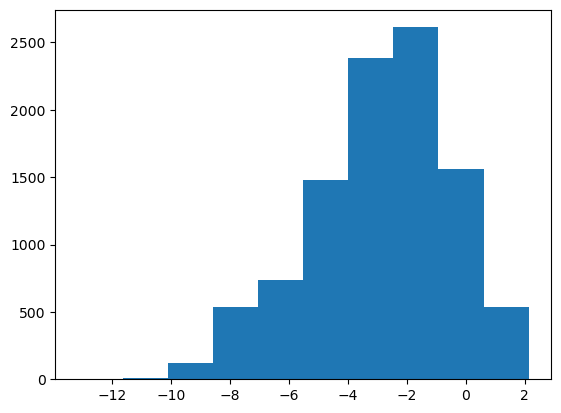

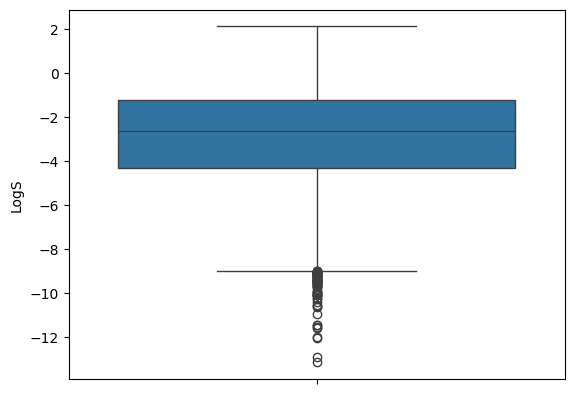

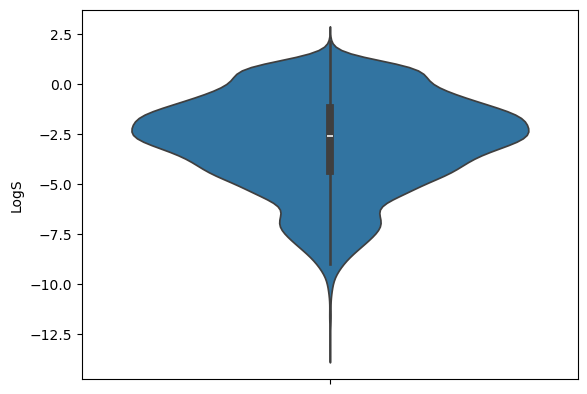

In [7]:
plt.hist(df_mordred["LogS"])
plt.show()

sns.boxplot(df_mordred["LogS"])
plt.show()

sns.violinplot(df_mordred["LogS"])
plt.show()


**Correlation-based Feature Reduction (Mordred)**  

Highly correlated or zero-variance descriptors can amplify noise and reduce generalization:

In [8]:
# Simple redundancy reduction: remove highly correlated descriptors
df_num = df_mordred.select_dtypes(include='number').copy()
df_num_no_y = df_num.drop(columns="LogS")

corr_matrix = df_num_no_y.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.9
# Drop any descriptor that is >0.9 correlated with another
to_drop = [c for c in upper.columns if any(upper[c] > threshold)]

df_mordred_reduced = df_num_no_y.drop(columns=to_drop)
df_mordred_reduced = pd.concat(
    [df[['SMILES', 'Standardized_SMILES', 'LogS']], df_mordred_reduced],
    axis=1
)
df_mordred_reduced.to_csv(
    "./data/AqSolDB_Standardized_Mordred_Reduced.csv", index=False
)

Removing redundancy ensures the model focuses on unique chemical signals.

 **Mordred Models: Common Split, SVR & RF**

We now split the Mordred feature matrix into train and test sets and train SVR and Random Forest models to obtain baseline LogS predictions and understand overfitting vs generalization.

In [9]:
# Use Mordred descriptors as features (columns after LogS)
X = df_mordred.iloc[:, 3:]
y = df_mordred['LogS']

# Keep only numeric columns and handle infinities and missing values
X = X.select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)

# Require at least 80% non‑missing values per feature
X = X.dropna(axis=1, thresh=0.8 * len(X))

# Impute remaining NaNs with column means
X = X.fillna(X.mean())

# Train/test split for baseline Mordred models (80/20 random split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} molecules")
print(f"Test set: {X_test.shape[0]} molecules")


Training set: 7985 molecules
Test set: 1997 molecules


**Train and Evaluate SVR**

Mordred-SVR Test:
  MAE:  0.756
  RMSE: 1.080
  R²:   0.785


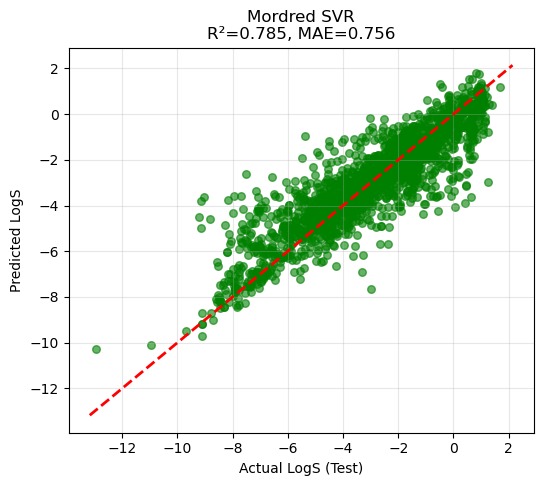

['models/mordred_svr.pkl']

In [11]:
# Standardize features for SVR (RF will use unscaled features)
scaler_mordred = StandardScaler()
X_train_scaled = scaler_mordred.fit_transform(X_train)
X_test_scaled = scaler_mordred.transform(X_test)

# Baseline SVR with RBF kernel on Mordred descriptors
svm_mordred = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
svm_mordred.fit(X_train_scaled, y_train)

y_pred_svr = svm_mordred.predict(X_test_scaled)

mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("Mordred-SVR Test:")
print(f"  MAE:  {mae_svr:.3f}")
print(f"  RMSE: {rmse_svr:.3f}")
print(f"  R²:   {r2_svr:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_svr, alpha=0.6, s=30, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual LogS (Test)')
plt.ylabel('Predicted LogS')
plt.title(f'Mordred SVR\nR²={r2_svr:.3f}, MAE={mae_svr:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

joblib.dump(
    {'model': svm_mordred, 'scaler': scaler_mordred, 'features': X.columns.tolist()},
    'models/mordred_svr.pkl'
)


**Train and Evaluate RF**


Mordred-RF TRAIN:
  R²:   0.9640
  RMSE: 0.4509
  MAE:  0.2851

Mordred-RF TEST:
  R²:   0.8221
  RMSE: 0.9823
  MAE:  0.6812

Overfitting gap (train R² - test R²): 0.1419


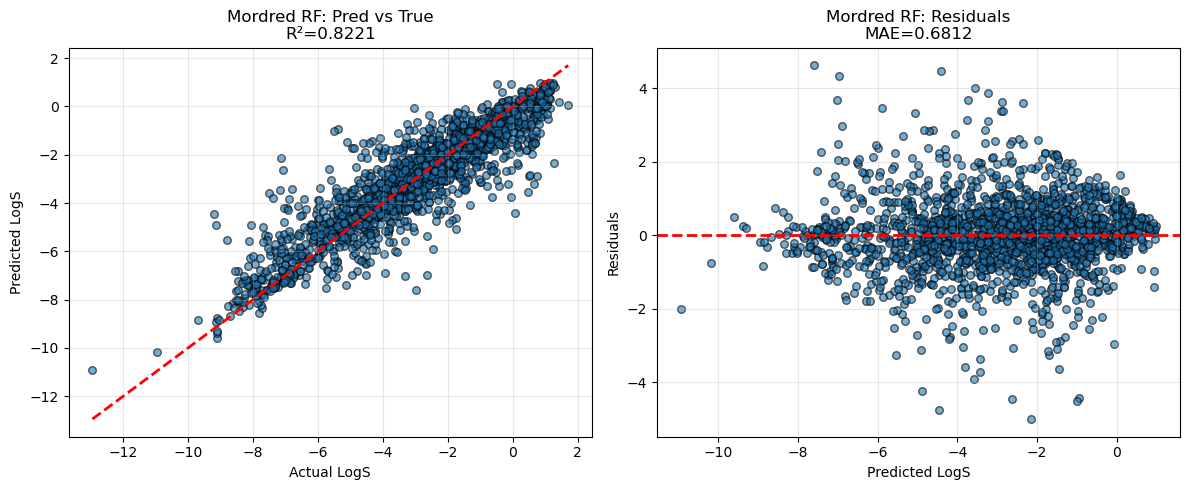

['models/mordred_rf.pkl']

In [12]:
# Random Forest on Mordred descriptors with chosen hyperparameters
rf_mordred = RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_mordred.fit(X_train, y_train)

y_pred_train_rf = rf_mordred.predict(X_train)
y_pred_test_rf = rf_mordred.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train_rf)
test_r2 = r2_score(y_test, y_pred_test_rf)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
train_mae = mean_absolute_error(y_train, y_pred_train_rf)
test_mae = mean_absolute_error(y_test, y_pred_test_rf)

print("\nMordred-RF TRAIN:")
print(f"  R²:   {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")

print("\nMordred-RF TEST:")
print(f"  R²:   {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")

gap = train_r2 - test_r2
print(f"\nOverfitting gap (train R² - test R²): {gap:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, y_pred_test_rf, alpha=0.6, edgecolors='k', s=30)
min_val = min(y_test.min(), y_pred_test_rf.min())
max_val = max(y_test.max(), y_pred_test_rf.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0].set_xlabel('Actual LogS')
axes[0].set_ylabel('Predicted LogS')
axes[0].set_title(f'Mordred RF: Pred vs True\nR²={test_r2:.4f}')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test_rf
axes[1].scatter(y_pred_test_rf, residuals, alpha=0.6, edgecolors='k', s=30)
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted LogS')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Mordred RF: Residuals\nMAE={test_mae:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

joblib.dump(
    {"model": rf_mordred, "features": X_train.columns.tolist()},
    "models/mordred_rf.pkl"
)


**MACCS Pipeline**

In parallel to Mordred, we build a second pipeline using **MACCS keys**, perform a train/test split at the molecule ID level, and tune RF and SVR with cross-validation.

MACCS keys represent each molecule as a fixed‑length bit vector, where each bit indicates the presence or absence of a predefined substructure or functional group.  
They capture patterns such as *aromatic rings*, *polar functional groups*, and *hydrophobic fragments* in a very compact way, which makes them a good contrast to the richer, continuous Mordred descriptors.

**Data, IDs, Train/Test Split**

In [13]:
# Define folder structure for data, processed features, models, and results
BASE = Path('.')
DATA_DIR = BASE / 'data'
SPLITS_DIR = DATA_DIR / 'splits'
PROC_DIR = DATA_DIR / 'processed'
MODELS_DIR = Path('models')
FIG_DIR = Path('figures')
RESULTS_DIR = Path('results')

for d in [DATA_DIR, SPLITS_DIR, PROC_DIR, MODELS_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Try to locate a standardized AqSolDB file among several candidates
STD_CSV_CANDIDATES = [
    'AqSolDB_Standardized.csv',
    DATA_DIR / 'AqSolDB_Standardized.csv',
    'AqSolDB_clean.csv',
    DATA_DIR / 'AqSolDB_clean.csv'
]

def find_standardized_csv(candidates: Sequence[Path]) -> Path:
    for c in candidates:
        c = Path(c)
        if c.exists():
            return c
    raise FileNotFoundError("Place 'AqSolDB_Standardized.csv' next to this notebook or in ./data/")

# Guess which columns contain SMILES and LogS-like targets
def guess_columns(df: pd.DataFrame) -> Tuple[str, str]:
    smiles_candidates = [c for c in df.columns if 'smiles' in c.lower()]
    if not smiles_candidates:
        raise ValueError(f"No SMILES-like column found. Columns: {list(df.columns)}")
    smiles_col = smiles_candidates[0]
    y_candidates = [
        c for c in df.columns
        if c.lower() in ('logs','log_s','logsol','log_solu','target','y','solubility','aqsol')
    ]
    if not y_candidates:
        numeric_cols = [
            c for c in df.columns
            if c != smiles_col and pd.api.types.is_numeric_dtype(df[c])
        ]
        if not numeric_cols:
            raise ValueError("No numeric target column found. Rename your target to 'LogS'.")
        y_col = numeric_cols[0]
    else:
        y_col = y_candidates[0]
    return smiles_col, y_col

std_path = find_standardized_csv(STD_CSV_CANDIDATES)
df_std = pd.read_csv(std_path)

smiles_col, y_col = guess_columns(df_std)

# Create or reuse a canonical ID per molecule so train/test split is at molecule level
id_col = None
for c in ['inchikey', 'InChIKey', 'canonical_smiles', 'can_smiles', 'id']:
    if c in df_std.columns:
        id_col = c
        break

if id_col is None:
    def to_canonical(s):
        try:
            m = Chem.MolFromSmiles(str(s))
            return Chem.MolToSmiles(m, canonical=True) if m is not None else None
        except Exception:
            return None
    df_std['canonical_smiles'] = df_std[smiles_col].apply(to_canonical)
    id_col = 'canonical_smiles'

df_std = df_std.dropna(subset=[id_col, y_col]).copy()
df_std = df_std.drop_duplicates(subset=[id_col]).copy()

# Split unique molecule IDs into train/test and save split files
unique_ids = df_std[id_col].tolist()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=SEED)
train_ids, test_ids = set(train_ids), set(test_ids)

(SPLITS_DIR / 'train_ids.txt').write_text("\n".join(sorted(train_ids)))
(SPLITS_DIR / 'test_ids.txt').write_text("\n".join(sorted(test_ids)))

df_train = df_std[df_std[id_col].isin(train_ids)].copy()
df_test  = df_std[df_std[id_col].isin(test_ids)].copy()


**MACCS Featurization**

In [14]:
# Convert molecules to MACCS fingerprints (167 bits) and build feature tables
def maccs_fp(mol: Chem.Mol) -> Optional[np.ndarray]:
    if mol is None:
        return None
    try:
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        # Convert bitstring to a numpy array of 0/1 integers
        return (
            np.frombuffer(fp.ToBitString().encode('ascii'), dtype='S1')
            .astype(np.uint8) - ord(b'0')
        )
    except Exception:
        return None

def make_maccs_frame(df_part: pd.DataFrame, smiles_col: str, id_col: str, y_col: str) -> pd.DataFrame:
    recs = []
    for _id, s, y in zip(df_part[id_col], df_part[smiles_col], df_part[y_col]):
        mol = Chem.MolFromSmiles(str(s))
        arr = maccs_fp(mol)
        if arr is None:
            continue
        recs.append({
            '_id': _id,
            'y': float(y),
            **{f'b{i}': int(arr[i]) for i in range(len(arr))}
        })
    return pd.DataFrame.from_records(recs)

Xy_train = make_maccs_frame(df_train, smiles_col, id_col, y_col)
Xy_test  = make_maccs_frame(df_test,  smiles_col, id_col, y_col)

bit_cols = [c for c in Xy_train.columns if c.startswith('b')]
bit_cols.sort(key=lambda z: int(z[1:]))
assert len(bit_cols) == 167

X_train_maccs = Xy_train[bit_cols].to_numpy(dtype=np.uint8)
y_train_maccs = Xy_train['y'].to_numpy(dtype=float)
X_test_maccs  = Xy_test[bit_cols].to_numpy(dtype=np.uint8)
y_test_maccs  = Xy_test['y'].to_numpy(dtype=float)

PROC_DIR.mkdir(parents=True, exist_ok=True)
np.save(PROC_DIR / 'maccs_X_train.npy', X_train_maccs)
np.save(PROC_DIR / 'maccs_y_train.npy', y_train_maccs)
np.save(PROC_DIR / 'maccs_X_test.npy', X_test_maccs)
np.save(PROC_DIR / 'maccs_y_test.npy', y_test_maccs)


**MACCS RF + SVR with GridSearch**

In [15]:
# 5‑fold CV grids for MACCS‑RF and MACCS‑SVR, optimized for RMSE
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_root_mean_squared_error'

rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
rf_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [None, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4]
}

svr = SVR(kernel='rbf')
svr_grid = {
    'C': [1.0, 10.0, 100.0, 300.0],
    'gamma': ['scale', 0.01, 0.03, 0.1, 0.3],
    'epsilon': [0.01, 0.05, 0.1, 0.2]
}

# Grid search over RF hyperparameters on MACCS features
rf_search = GridSearchCV(
    rf, rf_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1
)
rf_search.fit(X_train_maccs, y_train_maccs)
print("Best RF params:", rf_search.best_params_)

# Grid search over SVR hyperparameters on MACCS features
svr_search = GridSearchCV(
    svr, svr_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1
)
svr_search.fit(X_train_maccs, y_train_maccs)
print("Best SVR params:", svr_search.best_params_)

MODELS_DIR.mkdir(exist_ok=True)
joblib.dump(rf_search.best_estimator_, MODELS_DIR / 'maccs_rf.joblib')
joblib.dump(svr_search.best_estimator_, MODELS_DIR / 'maccs_svr.joblib')

RESULTS_DIR.mkdir(exist_ok=True)
with open(RESULTS_DIR / 'maccs_rf_cv.json', 'w') as f:
    json.dump(
        {'best_params': rf_search.best_params_,
         'best_score_neg_rmse': float(rf_search.best_score_)},
        f, indent=2
    )
with open(RESULTS_DIR / 'maccs_svr_cv.json', 'w') as f:
    json.dump(
        {'best_params': svr_search.best_params_,
         'best_score_neg_rmse': float(svr_search.best_score_)},
        f, indent=2
    )


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 800}
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best SVR params: {'C': 10.0, 'epsilon': 0.2, 'gamma': 'scale'}


**MACCS Test Evaluation + Plots**

In [16]:
rf_best  = joblib.load(MODELS_DIR / 'maccs_rf.joblib')
svr_best = joblib.load(MODELS_DIR / 'maccs_svr.joblib')

def evaluate_maccs(name, model, X, y):
    yhat = model.predict(X)
    return {
        'model': name,
        'rmse': mean_squared_error(y, yhat),
        'mae': mean_absolute_error(y, yhat),
        'r2': r2_score(y, yhat),
        'yhat': yhat,
    }

res_rf  = evaluate_maccs('MACCS-RF',  rf_best,  X_test_maccs, y_test_maccs)
res_svr = evaluate_maccs('MACCS-SVR', svr_best, X_test_maccs, y_test_maccs)

metrics_df = pd.DataFrame(
    [
        {k: v for k, v in res_rf.items()  if k != 'yhat'},
        {k: v for k, v in res_svr.items() if k != 'yhat'}
    ]
).sort_values('rmse')

metrics_df.to_csv(RESULTS_DIR / 'maccs_test_metrics.csv', index=False)
metrics_df


model      rmse       mae        r2
1  MACCS-SVR  1.335761  0.817981  0.753761
0   MACCS-RF  1.547634  0.887335  0.714703

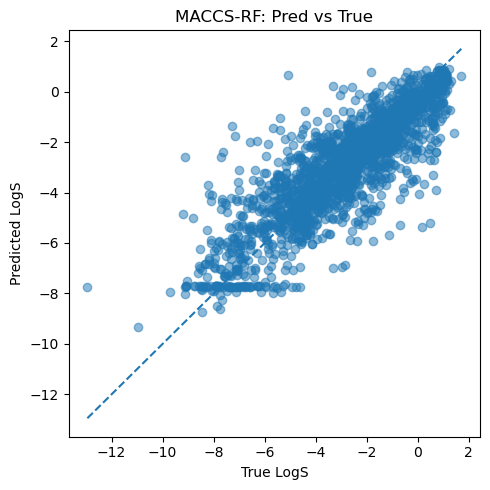

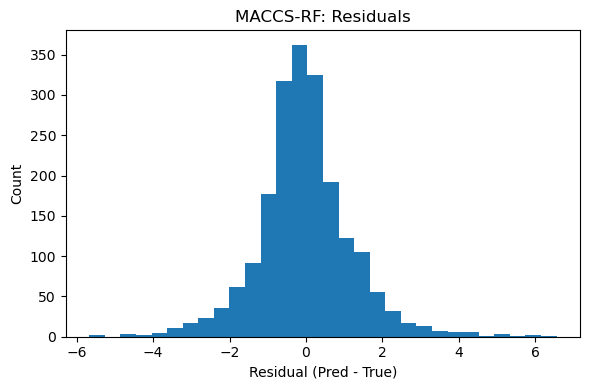

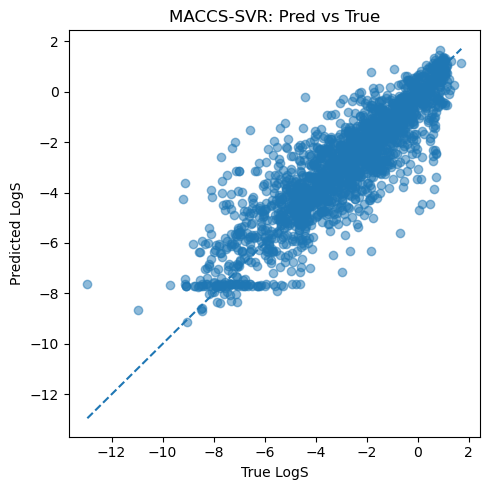

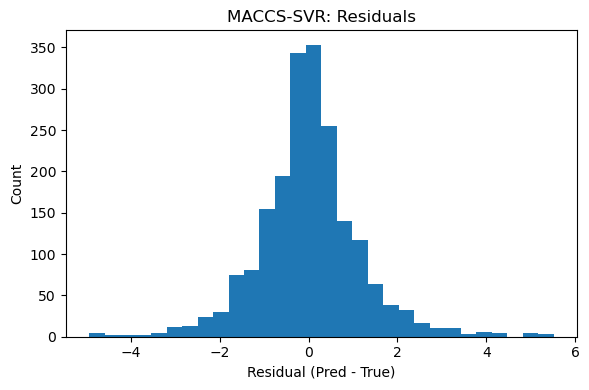

In [17]:
FIG_DIR.mkdir(exist_ok=True)

def plot_pred_vs_true(y_true, y_pred, title, savepath):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--')
    plt.xlabel('True LogS')
    plt.ylabel('Predicted LogS')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()

def plot_residuals(y_true, y_pred, title, savepath):
    resid = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.hist(resid, bins=30)
    plt.xlabel('Residual (Pred - True)')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()

plot_pred_vs_true(
    y_test_maccs, res_rf['yhat'],
    'MACCS-RF: Pred vs True',
    FIG_DIR / 'maccs_rf_pred_vs_true.png'
)
plot_residuals(
    y_test_maccs, res_rf['yhat'],
    'MACCS-RF: Residuals',
    FIG_DIR / 'maccs_rf_residuals.png'
)
plot_pred_vs_true(
    y_test_maccs, res_svr['yhat'],
    'MACCS-SVR: Pred vs True',
    FIG_DIR / 'maccs_svr_pred_vs_true.png'
)
plot_residuals(
    y_test_maccs, res_svr['yhat'],
    'MACCS-SVR: Residuals',
    FIG_DIR / 'maccs_svr_residuals.png'
)


**MACCS Helper: Predict New SMILES**

In [18]:
def predict_logs_for_smiles(smiles_list: List[str], model_name='rf'):
    path = MODELS_DIR / ('maccs_rf.joblib' if model_name.lower() == 'rf' else 'maccs_svr.joblib')
    model = joblib.load(path)
    mats = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            raise ValueError(f"Invalid SMILES: {s}")
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        arr = (
            np.frombuffer(fp.ToBitString().encode('ascii'), dtype='S1')
            .astype(np.uint8) - ord(b'0')
        )
        mats.append(arr)
    X_new = np.vstack(mats)
    return model.predict(X_new)


# *Models on Challenge Datasets*

Finally, we apply both Mordred- and MACCS-based models to the challenge datasets to test how well they extrapolate beyond the original AqSolDB distribution.


In [19]:
# ==== Mordred-based predictions on challenge data (RF or SVR) ====

MORDRED_TRAIN_FILE = "./data/AqSolDB_Standardized_Mordred.csv"
mordred_rf_path  = "models/mordred_rf.pkl"
mordred_svr_path = "models/mordred_svr.pkl"   

# For each challenge CSV: standardize SMILES, recompute Mordred descriptors,
# align feature columns with training set, and evaluate Mordred RF/SVR
def mordred_standardize_and_describe(challenge_csv: str, out_prefix: str):
    """Standardize SMILES, compute Mordred descriptors, clean/impute, and return df_ready."""
    df = pd.read_csv(challenge_csv)

    # 1) standardize SMILES exactly as before
    def standardize_molecule(mol):
        try:
            cleaner = rdMolStandardize.Cleanup(mol)
            normalizer = rdMolStandardize.Normalize(cleaner)
            reionizer = rdMolStandardize.Reionize(normalizer)
            return reionizer
        except:
            return mol

    standardized_smiles = []
    for smi in df['SMILES']:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mol = standardize_molecule(mol)
            clean_smi = Chem.MolToSmiles(mol, canonical=True)
            standardized_smiles.append(clean_smi)
        else:
            standardized_smiles.append(None)

    df['Standardized_SMILES'] = standardized_smiles
    # drop rows where standardization failed
    df = df.dropna(subset=['Standardized_SMILES']).reset_index(drop=True)

    # 2) Mordred descriptors
    mol_list = []
    for smi in df["Standardized_SMILES"]:
        m = Chem.MolFromSmiles(str(smi))
        if m is None:
            continue
        mol_list.append(m)

    # keep only rows where mol is valid
    df = df.iloc[:len(mol_list)].copy()

    calc = Calculator(descriptors, ignore_3D=True)
    desc_df = calc.pandas(mol_list).apply(pd.to_numeric, errors='coerce')

    df_desc = pd.concat([df[['SMILES', 'Standardized_SMILES', 'LogS']], desc_df], axis=1)
    df_desc.dropna(axis=1, how="all", inplace=True)
    df_desc.dropna(axis=0, thresh=len(df_desc.columns) * 0.9, inplace=True)
    df_desc.dropna(axis=1, how="all", inplace=True)

    # 3) simple mean imputation on remaining NaNs
    meta = df_desc[['SMILES', 'Standardized_SMILES', 'LogS']]
    feats = df_desc.drop(columns=['SMILES', 'Standardized_SMILES', 'LogS'])
    imp = SimpleImputer(missing_values=np.nan, strategy="mean")
    feats_imputed = pd.DataFrame(
        imp.fit_transform(feats),
        columns=feats.columns,
        index=feats.index
    )

    final_df = pd.concat([meta, feats_imputed], axis=1)
    final_df.to_csv(f"{out_prefix}_mordred_imputed.csv", index=False)
    return final_df

# Apply MACCS RF and SVR to challenge datasets and, if ground truth is present,
# compute RMSE, MAE, and R²; always save predictions to results/ for inspection
def evaluate_challenge_mordred(challenge_csv: str, model_type="rf"):
    """
    Use trained Mordred RF or SVR model on a challenge set.
    model_type: 'rf' or 'svr'
    """
    # prepare challenge descriptors
    stem = Path(challenge_csv).stem
    df_ch = mordred_standardize_and_describe(challenge_csv, f"results/{stem}")

    # load training Mordred descriptor columns so we align features
    df_train_mordred = pd.read_csv(MORDRED_TRAIN_FILE)
    feature_cols = df_train_mordred.columns[3:]  # Mordred columns (after SMILES, Standardized_SMILES, LogS)

    # align columns
    missing = set(feature_cols) - set(df_ch.columns)
    for col in missing:
        df_ch[col] = 0.0
    
    #X_ch = df_ch[feature_cols]
    #y_true = df_ch['LogS'].values

    if model_type.lower() == "rf":
        packed_rf = joblib.load(mordred_rf_path)
        model = packed_rf["model"]
        rf_feats = packed_rf["features"]  # list of columns actually used at training
        X_in = df_ch[rf_feats].values
    else:
        packed = joblib.load(mordred_svr_path)
        model = packed["model"]
        scaler = packed["scaler"]
        svr_feats = packed["features"]
        X_in = scaler.transform(df_ch[svr_feats])

    y_true = df_ch["LogS"].values
    y_pred = model.predict(X_in)

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r  = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"\nMordred-{model_type.upper()} on {challenge_csv}:")
    print(f"  R²:   {r2:.4f}")
    print(f"  RMSE: {r:.4f}")
    print(f"  MAE:  {mae:.4f}")

    # simple scatter plot
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=30)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel("Actual LogS")
    plt.ylabel("Predicted LogS")
    plt.title(f"{Path(challenge_csv).name} – Mordred-{model_type.upper()}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return r2, mae, r, y_true, y_pred


 15%|█▍        | 257/1763 [00:22<02:27, 10.23it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1763/1763 [02:27<00:00, 11.99it/s]



Mordred-RF on ./data/challenge_data_1.csv:
  R²:   -0.5716
  RMSE: 1.2104
  MAE:  0.9505


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


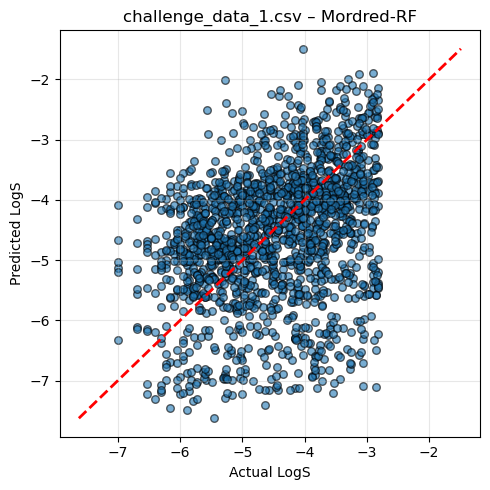

 54%|█████▍    | 1172/2170 [01:09<00:43, 23.11it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 2170/2170 [02:09<00:00, 16.73it/s]



Mordred-RF on ./data/challenge_data_2.csv:
  R²:   -25.2157
  RMSE: 3.6369
  MAE:  3.4609


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


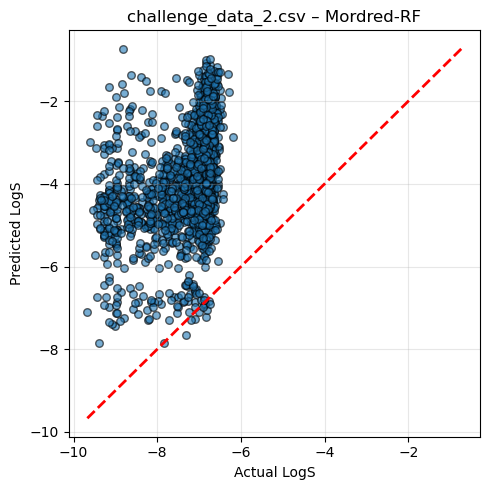

 15%|█▍        | 257/1763 [00:21<02:10, 11.50it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1763/1763 [02:29<00:00, 11.81it/s]



Mordred-SVR on ./data/challenge_data_1.csv:
  R²:   -0.3340
  RMSE: 1.1152
  MAE:  0.8869


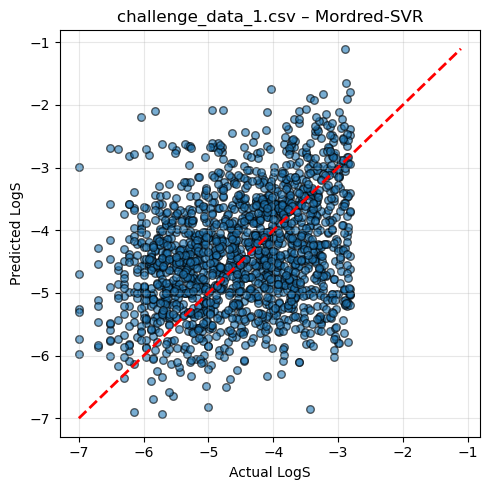

 54%|█████▍    | 1172/2170 [01:03<00:38, 26.14it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 2170/2170 [01:59<00:00, 18.17it/s]



Mordred-SVR on ./data/challenge_data_2.csv:
  R²:   -26.9811
  RMSE: 3.7574
  MAE:  3.5964


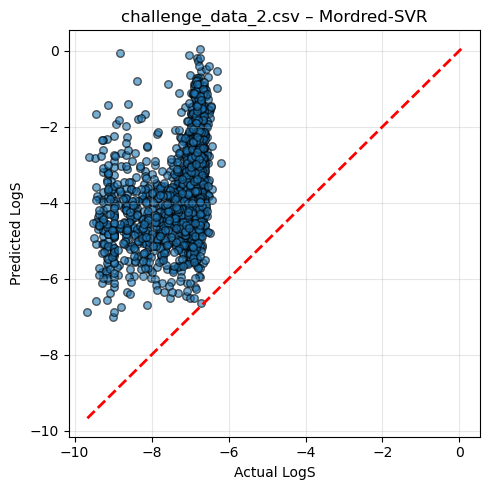

(-26.981090355873338,
 3.5963693745685905,
 3.757391769808889,
 array([-8.5480197 , -8.07140899, -6.9259694 , ..., -8.86645779,
        -6.73342435, -7.03731866]),
 array([-4.46648313, -4.66417472, -5.3693558 , ..., -5.23947393,
        -4.30343893, -1.3719993 ]))

In [21]:
evaluate_challenge_mordred("./data/challenge_data_1.csv", model_type="rf")
evaluate_challenge_mordred("./data/challenge_data_2.csv", model_type="rf")


evaluate_challenge_mordred("./data/challenge_data_1.csv", model_type="svr")
evaluate_challenge_mordred("./data/challenge_data_2.csv", model_type="svr")

In [22]:
CHALLENGE_FILES = [
    "./data/challenge_data_1.csv",
    "./data/challenge_data_2.csv",
]

TARGET_NAMES = {
    "logs", "log_s", "logsol", "log_solu",
    "target", "y", "solubility", "aqsol"
}

def detect_cols(df: pd.DataFrame):
    smiles_cols = [c for c in df.columns if "smiles" in c.lower()]
    if not smiles_cols:
        raise ValueError(f"No SMILES-like column found. Columns: {list(df.columns)}")
    smiles_col = smiles_cols[0]
    y_col = next((c for c in df.columns if c.lower() in TARGET_NAMES), None)
    return smiles_col, y_col

def canonicalize(s: str):
    m = Chem.MolFromSmiles(s)
    return Chem.MolToSmiles(m, canonical=True) if m is not None else None

def maccs_matrix(smiles_list):
    X, kept = [], []
    for s in smiles_list:
        m = Chem.MolFromSmiles(s)
        if m is None:
            continue
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(m)
        arr = (
            np.frombuffer(fp.ToBitString().encode("ascii"), dtype="S1")
            .astype(np.uint8) - ord(b"0")
        )
        X.append(arr)
        kept.append(s)
    if not X:
        raise RuntimeError("No valid molecules after featurization.")
    X = np.vstack(X)
    assert X.shape[1] == 167
    return X, kept

rf_ch  = joblib.load(MODELS_DIR / "maccs_rf.joblib")
svr_ch = joblib.load(MODELS_DIR / "maccs_svr.joblib")

def evaluate_challenge(csv_path: str):
    df_raw = pd.read_csv(csv_path)
    smiles_col, y_col = detect_cols(df_raw)

    df_raw["canonical_smiles"] = df_raw[smiles_col].map(canonicalize)
    df_c = df_raw.dropna(subset=["canonical_smiles"]).drop_duplicates("canonical_smiles").copy()

    X, ids = maccs_matrix(df_c["canonical_smiles"].tolist())

    pred_rf  = rf_ch.predict(X)
    pred_svr = svr_ch.predict(X)

    out_rf  = pd.DataFrame({"canonical_smiles": ids, "y_pred": pred_rf})
    out_svr = pd.DataFrame({"canonical_smiles": ids, "y_pred": pred_svr})

    metrics = {}
    if y_col is not None and pd.api.types.is_numeric_dtype(df_c[y_col]):
        y_true = df_c[y_col].astype(float).to_numpy()[:len(ids)]
        metrics = {
            "RF": {
                "rmse": np.sqrt(mean_squared_error(y_true, pred_rf)),
                "mae": float(np.mean(np.abs(y_true - pred_rf))),
                "r2": float(r2_score(y_true, pred_rf)),
            },
            "SVR": {
                "rmse": np.sqrt(mean_squared_error(y_true, pred_svr)),
                "mae": float(np.mean(np.abs(y_true - pred_svr))),
                "r2": float(r2_score(y_true, pred_svr)),
            },
        }

    stem = Path(csv_path).stem
    out_rf.to_csv(RESULTS_DIR / f"{stem}_predictions_rf.csv", index=False)
    out_svr.to_csv(RESULTS_DIR / f"{stem}_predictions_svr.csv", index=False)
    if metrics:
        with open(RESULTS_DIR / f"{stem}_metrics_maccs.json", "w") as f:
            json.dump(metrics, f, indent=2)

    return metrics, out_rf.head(), out_svr.head()

for f in CHALLENGE_FILES:
    print(f"\n=== {f} ===")
    m, head_rf, head_svr = evaluate_challenge(f)
    print(json.dumps(m, indent=2) if m else "No ground truth found.")
    display(head_rf, head_svr)



=== ./data/challenge_data_1.csv ===
{
  "RF": {
    "rmse": 1.201306872431348,
    "mae": 0.9768180209780745,
    "r2": -0.5470481084910339
  },
  "SVR": {
    "rmse": 1.3181586428469034,
    "mae": 1.066144834565119,
    "r2": -0.8626500099595908
  }
}


canonical_smiles    y_pred
0  COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc... -4.444664
1  CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc... -3.340945
2  N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4... -5.020178
3  CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B... -4.160930
4              N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1 -3.802295

canonical_smiles    y_pred
0  COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc... -3.432201
1  CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc... -3.778214
2  N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4... -5.159187
3  CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B... -3.690053
4              N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1 -2.663639


=== ./data/challenge_data_2.csv ===
{
  "RF": {
    "rmse": 3.882114956571222,
    "mae": 3.746322839266689,
    "r2": -28.93041063103437
  },
  "SVR": {
    "rmse": 3.9518775398518997,
    "mae": 3.789530858965217,
    "r2": -30.015790087984186
  }
}


canonical_smiles    y_pred
0  CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H... -4.198312
1  CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1 -4.651094
2  CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C... -5.026991
3  CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C... -3.979085
4  C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)... -4.453366

canonical_smiles    y_pred
0  CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H... -3.519288
1  CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1 -5.738684
2  CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C... -5.273443
3  CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C... -4.506670
4  C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)... -5.009181

**Manifest**

In [23]:
manifest = {
    'seed': SEED,
    'notes': 'AqSolDB Mordred & MACCS pipelines (RF + SVR)',
    'files': {
        'split_train': 'data/splits/train_ids.txt',
        'split_test': 'data/splits/test_ids.txt',
        'maccs_metrics_csv': 'results/maccs_test_metrics.csv',
        'maccs_rf_model': 'models/maccs_rf.joblib',
        'maccs_svr_model': 'models/maccs_svr.joblib',
        'mordred_rf_model': 'models/mordred_rf.pkl',
        'mordred_svr_model': 'models/mordred_svr.pkl',
    }
}
with open(RESULTS_DIR / 'run_manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)


### **The Importance of Data Provenance**  

In our baseline models, we treated AqSolDB as a homogeneous dataset and assumed that all LogS values were equally reliable. 
However, AqSolDB aggregates aqueous solubility measurements from nine different literature sources, each using distinct 
experimental protocols and solubility definitions (e.g. equilibrium vs kinetic solubility).  

As a result, aqueous solubility (LogS) is not a single clean number but a condition-dependent property. The reported LogS 
values reflect not only intrinsic chemical properties but also experimental variability arising from differences in assay type, 
experimental conditions, and data quality. This heterogeneity introduces noise into the learning target, meaning that part 
of the variance captured by our models corresponds to measurement noise rather than true chemical signal.   

Aqueous solubility is typically measured either via shake-flask (equilibrium) methods, where a compound is incubated in excess 
solvent and analyzed after equilibration, or via kinetic solubility assays, which are faster but can yield different values 
depending on solvent, temperature, and compound form. Each method represents provenance information that is often lost when merging datasets.   

Public solubility datasets, such as AqSolDB, normalize values into LogS and provide molecular identifiers and basic features. 
However, even after curation, the measurements reflect varying conditions, and the same compound can have LogS differences of ≥0.5 units 
across sources. These inconsistencies highlight why data provenance is critical for interpreting and modeling aqueous solubility.   

When flexible models like Support Vector Regression or Random Forests are trained on this mixed dataset without accounting for provenance or 
measurement reliability, they can partly fit dataset-specific noise, which explains why performance on familiar test splits may appear reasonable, 
yet generalization to challenging, unseen datasets is poor.   

This highlights that model performance metrics alone are insufficient without a clear understanding of how the target property 
was experimentally defined and measured. Thus, understanding the provenance of each measurement, including lab, experimental protocol, 
and solubility type, is essential for interpreting model performance and designing chemically meaningful pipelines.  


### **From Data Provenance to Molecular Representations**  

The experimental noise in the learning target, also directly affects which features are predictive and which are just capturing experimental artifacts, thus having a direct impact on feature selection and model learning. 

Thus, before diving into descriptors, it’s critical to remember that:   
- Features that correlate with noise (dataset-specific biases) may appear predictive but fail on new data.  
- Redundant descriptors amplify noise: correlated features make models more sensitive to variations in measurement conditions. 
- Sparse fingerprints (like MACCS) may “ignore” noisy patterns, sometimes leading to better generalization. 
  
Because of these provenance issues *Representation Analysis* is required, not just for computing Mordred or MACCS descriptors, but also to critically evaluate which descriptors actually capture true chemical signals. 

Understanding feature relevance in the context of noisy data helps us reduce overfitting and improve model robustness. 

Focussing on the molecular representations used in this task i.e., Mordred descriptors and MACCS keys, it is observed that although both Mordred and MACCS provide rich, high-dimensional encodings of molecular structure, but their raw outputs inevitably contain redundant, highly correlated, and sometimes weakly relevant features for solubility prediction. 

In a noisy target setting like AqSolDB, such features can amplify experimental artifacts: flexible models may latch onto dataset-specific patterns rather than true solubility chemistry. Thus, it becomes clear that not all descriptors should be treated as equally useful. 

To address this, chemical interpretation is used i.e., mapping descriptor categories to known solubility drivers (lipophilicity, polarity, size, charge, aromaticity) to focus on features that are chemically meaningful. 


**Selecting Chemically Meaningful Features**    

Solubility depends on fundamental physicochemical interactions between molecules and water, and from QSPR studies, five main molecular characteristics drive solubility:  

- *Hydrophobic-Hydrophilic Balance (Lipophilicity)*: Octanol-water partition coefficients (logP) capture the thermodynamic cost of transferring molecules from organic to aqueous environments. In our descriptor set, Mordred provides **SLogP**, while MACCS keys indicate hydrophobic patterns like **long carbon chains** or **halogenated aromatics**.  

- *Polarity and Hydrogen-Bonding Capacity*: Polar surface area and H-bond donors/acceptors increase solubility by stabilizing interactions with water. Mordred descriptors such as **TPSA, nHBDon, and nHBAccept** capture this effect; MACCS keys represent **hydroxyls, amides,** and **carbonyl groups**.  

- *Molecular Size and Shape*: Larger or bulkier molecules are generally less soluble. Mordred encodes **MW, van der Waals volume**, and **shape** indices; MACCS captures size via **ring and fragment counts**.  

- *Ionizable Functional Groups*: Acidic or basic groups increase solubility through favorable water interactions. Mordred and MACCS descriptors identify these features explicitly.  

- *Aromaticity and π-Systems*: Extended aromatic systems reduce solubility due to rigid hydrophobic surfaces and stacking interactions. Mordred descriptors for **aromatic atom counts** and MACCS keys for **(hetero)aromatic rings** capture this effect.  

From this, it is clear that only a subset of descriptors is chemically meaningful. To reduce redundancy and noise, we exclude features that are highly correlated, abstract, or poorly interpretable, retaining only those capturing the five solubility drivers above.  

This representation analysis is essential because, given the provenance issues, only features reflecting robust chemical effects are likely to generalize beyond AqSolDB and familiar test splits.  

*Despite careful selection, Mordred and MACCS descriptors cannot fully capture all factors affecting solubility. In particular, energetic contributions from crystal packing, solid-state form, and melting point are absent from these 2D representations. Graph-based representations and hybrid features can also be used to complement the current descriptors to improve prediction for challenging compounds.*

### **Beyond RMSE: how we evaluate LogS models**

Aqueous solubility (LogS) data are noisy and heterogeneous, so a single metric like RMSE or R² is not enough to judge model quality.  

Thus, we also used five complementary metrics: **Pearson r** and **distance correlation (dCor)** to capture linear and non‑linear association, **CCC** to measure agreement and calibration, and **MedianAE** and **Huber loss** to quantify robust error under outliers. 
 
Together, these metrics let us separate “trend” (does the model rank molecules correctly?) from “agreement” (are the numeric values on the right scale?) and from “robustness” (how sensitive are we to large errors?). 


In [24]:
# Task 4: 5-metric evaluation helpers (Pearson r, CCC, dCor, MedianAE, Huber)

from pathlib import Path
Path("figures/task4_5metrics").mkdir(parents=True, exist_ok=True)
Path("results").mkdir(exist_ok=True)

def pearson_r(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return np.nan
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def ccc(y_true, y_pred):
    x = np.asarray(y_true, float)
    y = np.asarray(y_pred, float)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(), y.var()
    cov = np.mean((x - mx) * (y - my))
    return float((2 * cov) / (vx + vy + (mx - my) ** 2 + 1e-12))

def distance_correlation(y_true, y_pred):
    x = np.asarray(y_true, float).reshape(-1, 1)
    y = np.asarray(y_pred, float).reshape(-1, 1)
    a = np.abs(x - x.T)
    b = np.abs(y - y.T)
    A = a - a.mean(axis=0, keepdims=True) - a.mean(axis=1, keepdims=True) + a.mean()
    B = b - b.mean(axis=0, keepdims=True) - b.mean(axis=1, keepdims=True) + b.mean()
    dcov2 = (A * B).mean()
    dvarx2 = (A * A).mean()
    dvary2 = (B * B).mean()
    if dvarx2 <= 0 or dvary2 <= 0:
        return 0.0
    return float(np.sqrt(max(dcov2, 0.0)) / np.sqrt(np.sqrt(dvarx2) * np.sqrt(dvary2) + 1e-12))

def median_ae(y_true, y_pred):
    return float(np.median(np.abs(np.asarray(y_true, float) - np.asarray(y_pred, float))))

def huber_loss(y_true, y_pred, epsilon=1.35):
    r = np.asarray(y_true, float) - np.asarray(y_pred, float)
    abs_r = np.abs(r)
    quad = np.minimum(abs_r, epsilon)
    return float(np.mean(0.5 * (quad ** 2) + epsilon * (abs_r - quad)))

def compute_5_metrics(y_true, y_pred, epsilon=1.35):
    return {
        "Pearson_r": pearson_r(y_true, y_pred),
        "CCC": ccc(y_true, y_pred),
        "dCor": distance_correlation(y_true, y_pred),
        "MedianAE": median_ae(y_true, y_pred),
        "HuberLoss": huber_loss(y_true, y_pred, epsilon=epsilon),
    }

def comprehensive_plot(y_true, y_pred, title, outpath, epsilon=1.35):
    """4-panel diagnostic plot + 5 metrics."""
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    resid = y_true - y_pred
    m = compute_5_metrics(y_true, y_pred, epsilon=epsilon)

    fig, axs = plt.subplots(2, 2, figsize=(11, 8.5))

    # (1) Pred vs True
    axs[0, 0].scatter(y_true, y_pred, s=10, alpha=0.5)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    axs[0, 0].plot([mn, mx], [mn, mx], linestyle="--")
    axs[0, 0].set_xlabel("True LogS")
    axs[0, 0].set_ylabel("Predicted LogS")
    axs[0, 0].set_title("Predicted vs True")

    # (2) Residuals vs Predicted
    axs[0, 1].scatter(y_pred, resid, s=10, alpha=0.5)
    axs[0, 1].axhline(0, linestyle="--")
    axs[0, 1].set_xlabel("Predicted LogS")
    axs[0, 1].set_ylabel("Residual (True - Pred)")
    axs[0, 1].set_title("Residuals vs Predicted")

    # (3) Residual histogram
    axs[1, 0].hist(resid, bins=40)
    axs[1, 0].set_xlabel("Residual (True - Pred)")
    axs[1, 0].set_ylabel("Count")
    axs[1, 0].set_title("Residual distribution")

    # (4) Metrics text
    axs[1, 1].axis("off")
    txt = "\n".join([
        f"Pearson r:  {m['Pearson_r']:.3f}",
        f"CCC:        {m['CCC']:.3f}",
        f"dCor:       {m['dCor']:.3f}",
        f"MedianAE:   {m['MedianAE']:.3f}",
        f"HuberLoss:  {m['HuberLoss']:.3f} (ε={epsilon})",
    ])
    axs[1, 1].text(0.02, 0.95, txt, va="top", fontsize=12)

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(outpath, dpi=200)
    plt.show()
    return m


dataset        model  Pearson_r     CCC    dCor  MedianAE  HuberLoss
0  test_split   Mordred-RF     0.9068  0.9016  0.8843    0.4423     0.4052
1  test_split  Mordred-SVR     0.8864  0.8769  0.8641    0.5144     0.4767

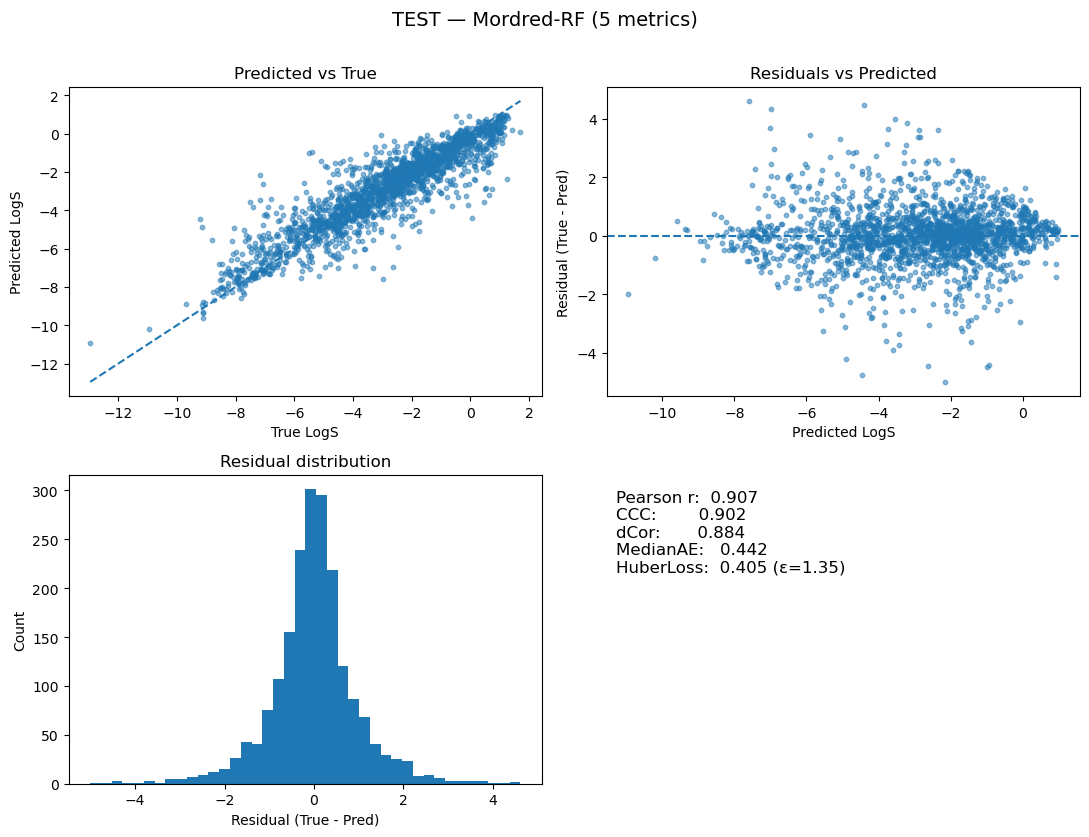

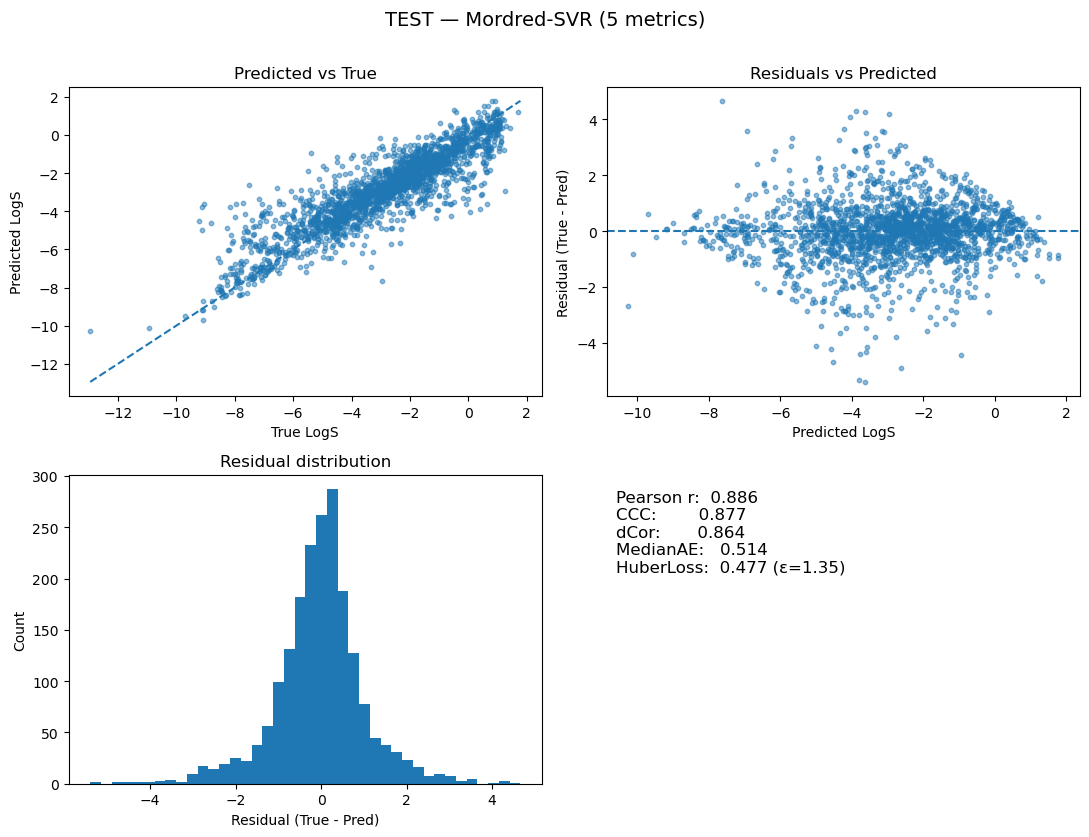

{'Pearson_r': 0.8863897350526223,
 'CCC': 0.8769090366772209,
 'dCor': 0.8641062506985288,
 'MedianAE': 0.5143611801753849,
 'HuberLoss': 0.47666610128060677}

In [25]:
# 5-metric evaluation on Mordred test split

# SVR predictions on Mordred test set
yhat_mordred_svr = y_pred_svr  # from your SVR block on Mordred features

# RF predictions on Mordred test set
yhat_mordred_rf = y_pred_test_rf  # from your RF block on Mordred features

rows = [
    {"dataset": "test_split", "model": "Mordred-RF",  **compute_5_metrics(y_test, yhat_mordred_rf)},
    {"dataset": "test_split", "model": "Mordred-SVR", **compute_5_metrics(y_test, yhat_mordred_svr)},
]
df_mordred_test_5 = pd.DataFrame(rows)
display(df_mordred_test_5.round(4))
df_mordred_test_5.to_csv("results/task4_mordred_test_5metrics.csv", index=False)

comprehensive_plot(y_test, yhat_mordred_rf,
                   "TEST — Mordred-RF (5 metrics)",
                   "figures/task4_5metrics/test_mordred_rf.png")

comprehensive_plot(y_test, yhat_mordred_svr,
                   "TEST — Mordred-SVR (5 metrics)",
                   "figures/task4_5metrics/test_mordred_svr.png")


 15%|█▍        | 257/1763 [00:20<01:57, 12.77it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1763/1763 [02:25<00:00, 12.14it/s]



Mordred-RF on ./data/challenge_data_1.csv:
  R²:   -0.5716
  RMSE: 1.2104
  MAE:  0.9505


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


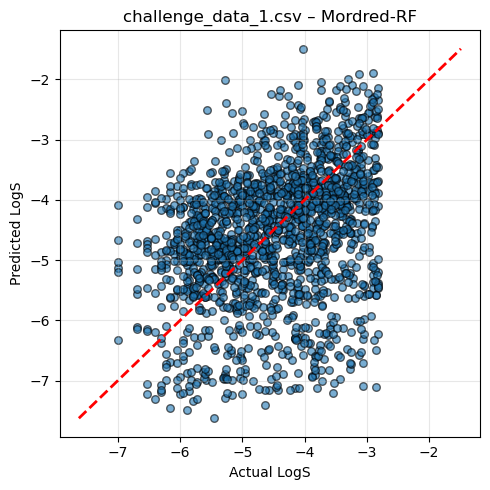

 54%|█████▍    | 1173/2170 [01:07<00:39, 25.47it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 2170/2170 [02:05<00:00, 17.31it/s]



Mordred-RF on ./data/challenge_data_2.csv:
  R²:   -25.2157
  RMSE: 3.6369
  MAE:  3.4609


/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


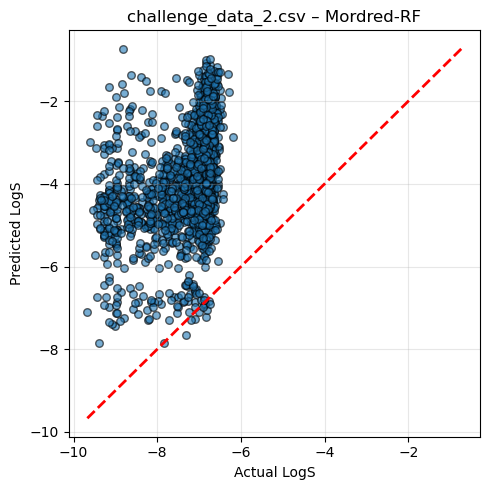

 15%|█▍        | 259/1763 [00:22<02:00, 12.50it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1763/1763 [02:21<00:00, 12.43it/s]



Mordred-SVR on ./data/challenge_data_1.csv:
  R²:   -0.3340
  RMSE: 1.1152
  MAE:  0.8869


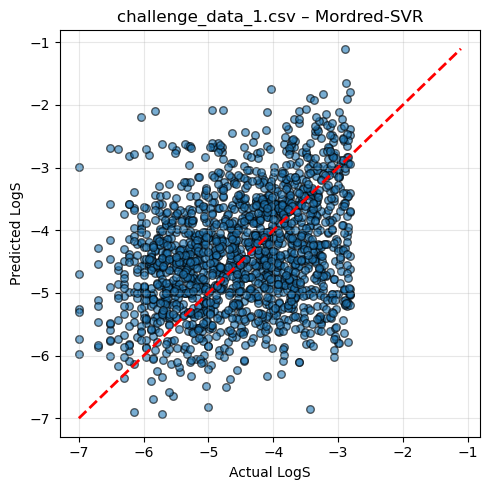

 54%|█████▍    | 1171/2170 [01:10<00:40, 24.54it/s]

/Users/aaryanjaitly/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 2170/2170 [02:08<00:00, 16.83it/s]



Mordred-SVR on ./data/challenge_data_2.csv:
  R²:   -26.9811
  RMSE: 3.7574
  MAE:  3.5964


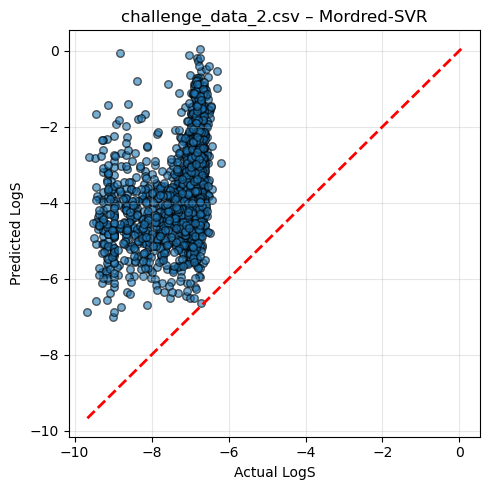

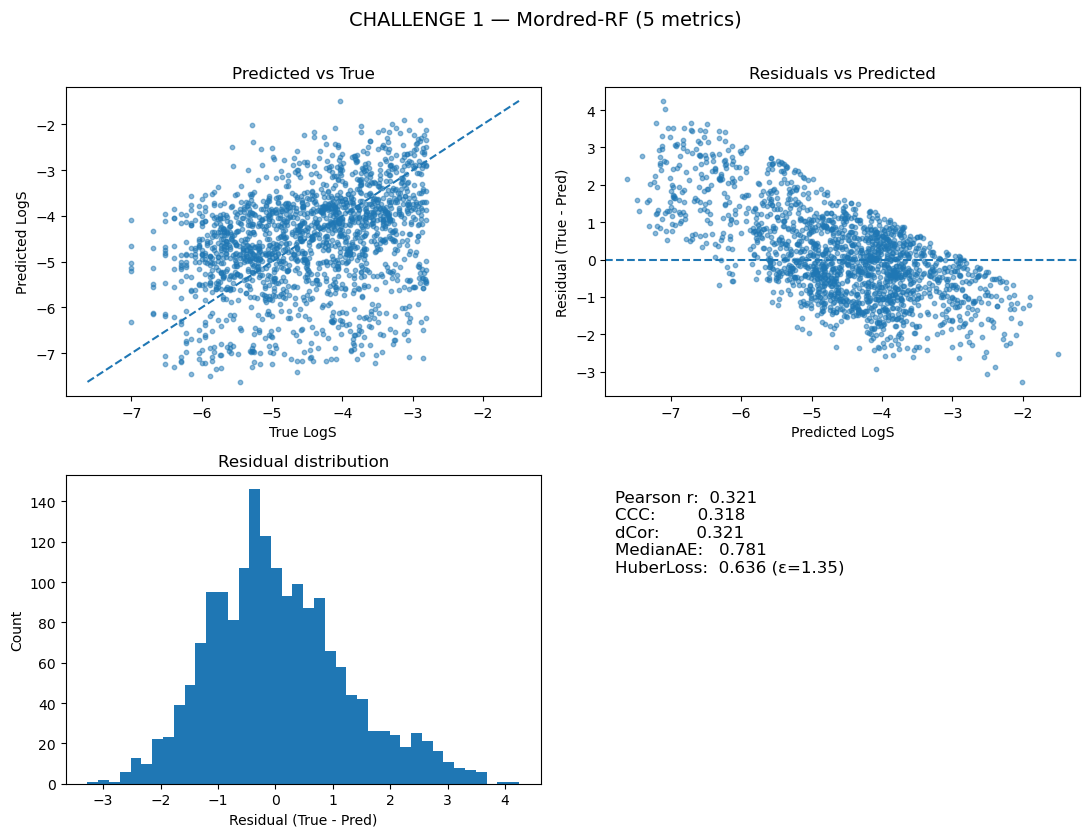

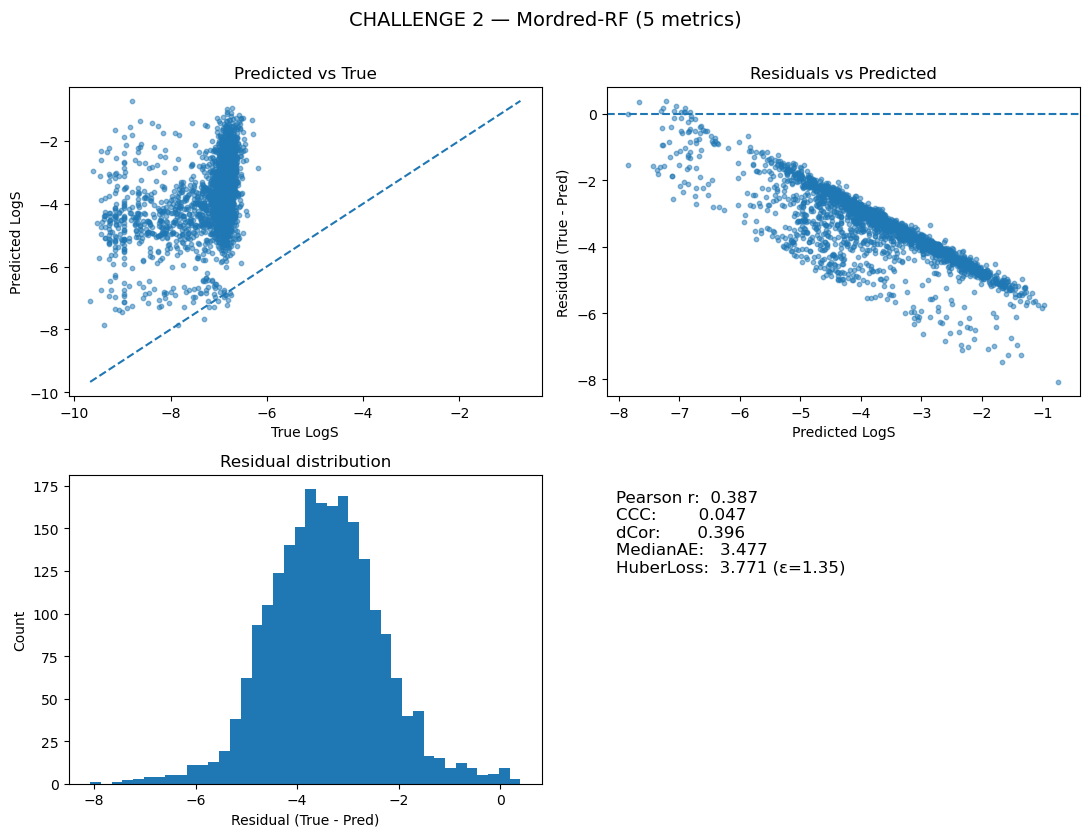

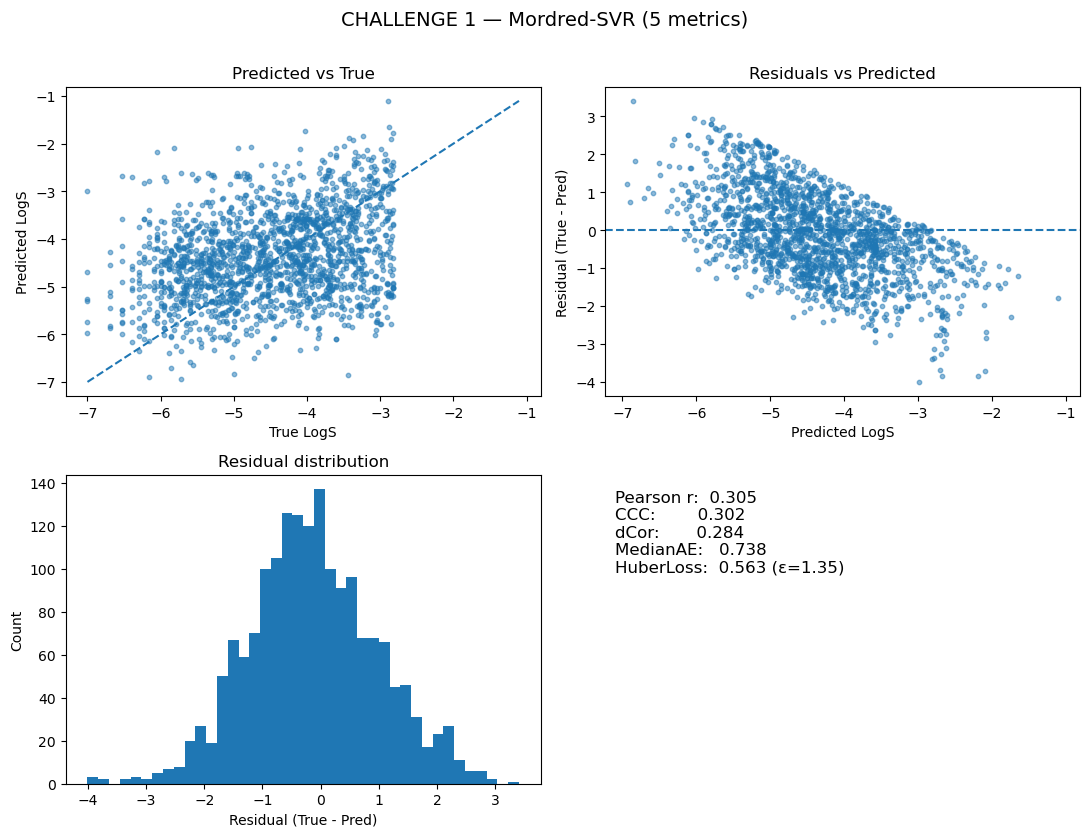

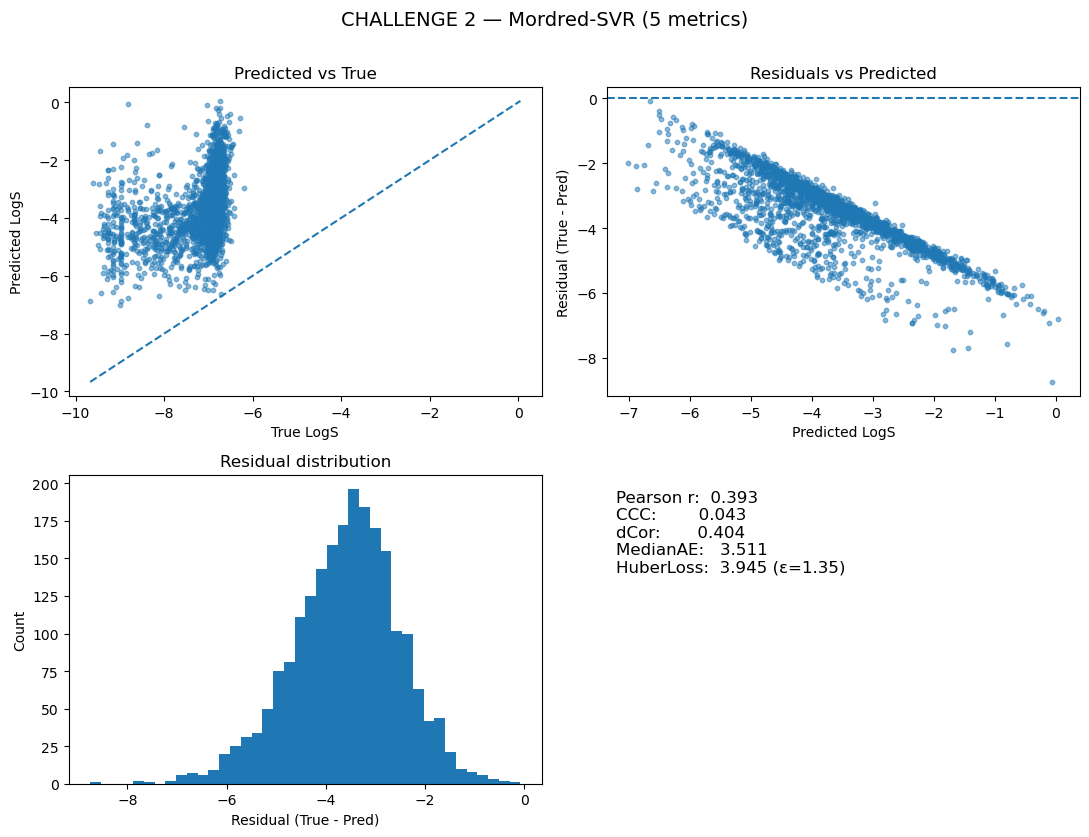

dataset        model  Pearson_r     CCC    dCor  MedianAE  HuberLoss
0  Challenge 1   Mordred-RF     0.3215  0.3181  0.3213    0.7810     0.6365
1  Challenge 1  Mordred-SVR     0.3052  0.3016  0.2840    0.7384     0.5633
2  Challenge 2   Mordred-RF     0.3872  0.0470  0.3963    3.4773     3.7708
3  Challenge 2  Mordred-SVR     0.3927  0.0434  0.4040    3.5110     3.9455

In [26]:
# Mordred RF/SVR on challenge sets with 5-metric diagnostics

r2_1_rf, mae_1_rf, rmse_1_rf, y1_true, y1_pred_rf = evaluate_challenge_mordred("./data/challenge_data_1.csv", model_type="rf")
r2_2_rf, mae_2_rf, rmse_2_rf, y2_true, y2_pred_rf = evaluate_challenge_mordred("./data/challenge_data_2.csv", model_type="rf")

r2_1_svr, mae_1_svr, rmse_1_svr, _,        y1_pred_svr = evaluate_challenge_mordred("./data/challenge_data_1.csv", model_type="svr")
r2_2_svr, mae_2_svr, rmse_2_svr, _,        y2_pred_svr = evaluate_challenge_mordred("./data/challenge_data_2.csv", model_type="svr")

metrics_ch1_rf  = comprehensive_plot(y1_true, y1_pred_rf,
                                     "CHALLENGE 1 — Mordred-RF (5 metrics)",
                                     "figures/task4_5metrics/ch1_mordred_rf.png")
metrics_ch2_rf  = comprehensive_plot(y2_true, y2_pred_rf,
                                     "CHALLENGE 2 — Mordred-RF (5 metrics)",
                                     "figures/task4_5metrics/ch2_mordred_rf.png")

metrics_ch1_svr = comprehensive_plot(y1_true, y1_pred_svr,
                                     "CHALLENGE 1 — Mordred-SVR (5 metrics)",
                                     "figures/task4_5metrics/ch1_mordred_svr.png")
metrics_ch2_svr = comprehensive_plot(y2_true, y2_pred_svr,
                                     "CHALLENGE 2 — Mordred-SVR (5 metrics)",
                                     "figures/task4_5metrics/ch2_mordred_svr.png")

df_mordred_5 = pd.DataFrame([
    {"dataset": "Challenge 1", "model": "Mordred-RF",  **metrics_ch1_rf},
    {"dataset": "Challenge 1", "model": "Mordred-SVR", **metrics_ch1_svr},
    {"dataset": "Challenge 2", "model": "Mordred-RF",  **metrics_ch2_rf},
    {"dataset": "Challenge 2", "model": "Mordred-SVR", **metrics_ch2_svr},
])
display(df_mordred_5.round(4))
df_mordred_5.to_csv("results/task4_mordred_challenge_5metrics.csv", index=False)


dataset      model  Pearson_r     CCC    dCor  MedianAE  HuberLoss
0  test_split   MACCS-RF     0.8463  0.8394  0.8182    0.6178     0.6089
1  test_split  MACCS-SVR     0.8693  0.8656  0.8439    0.5592     0.5386

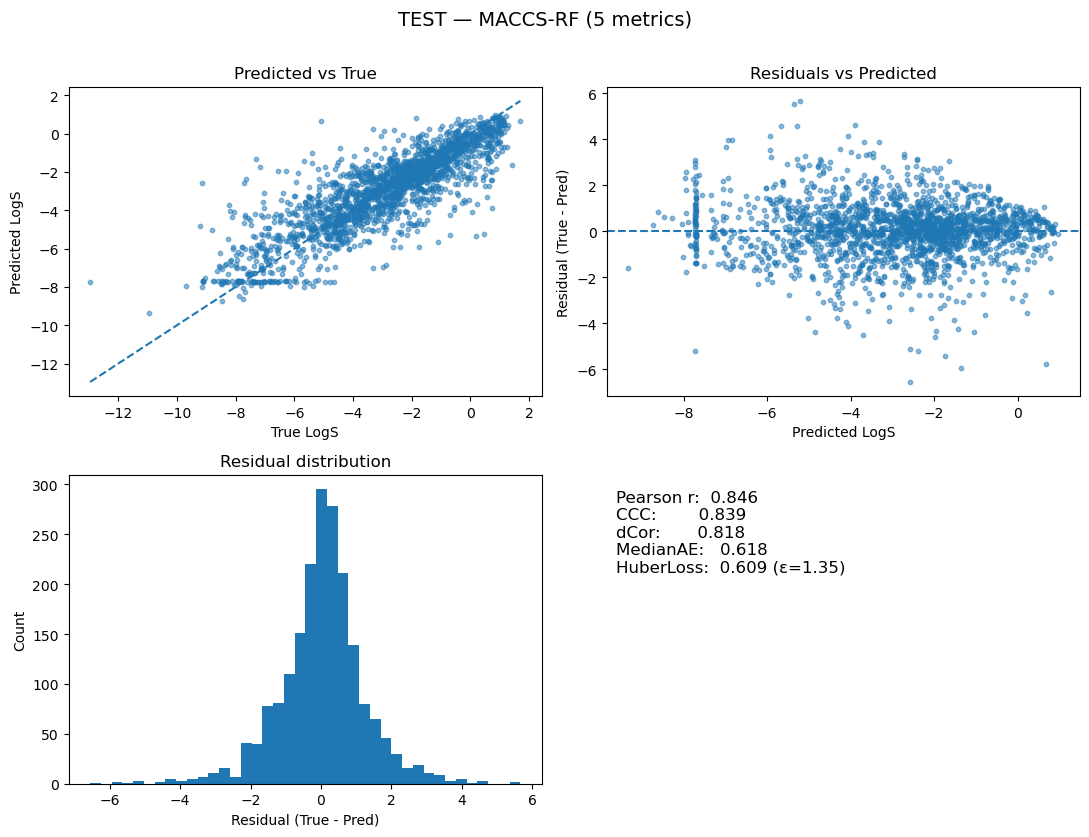

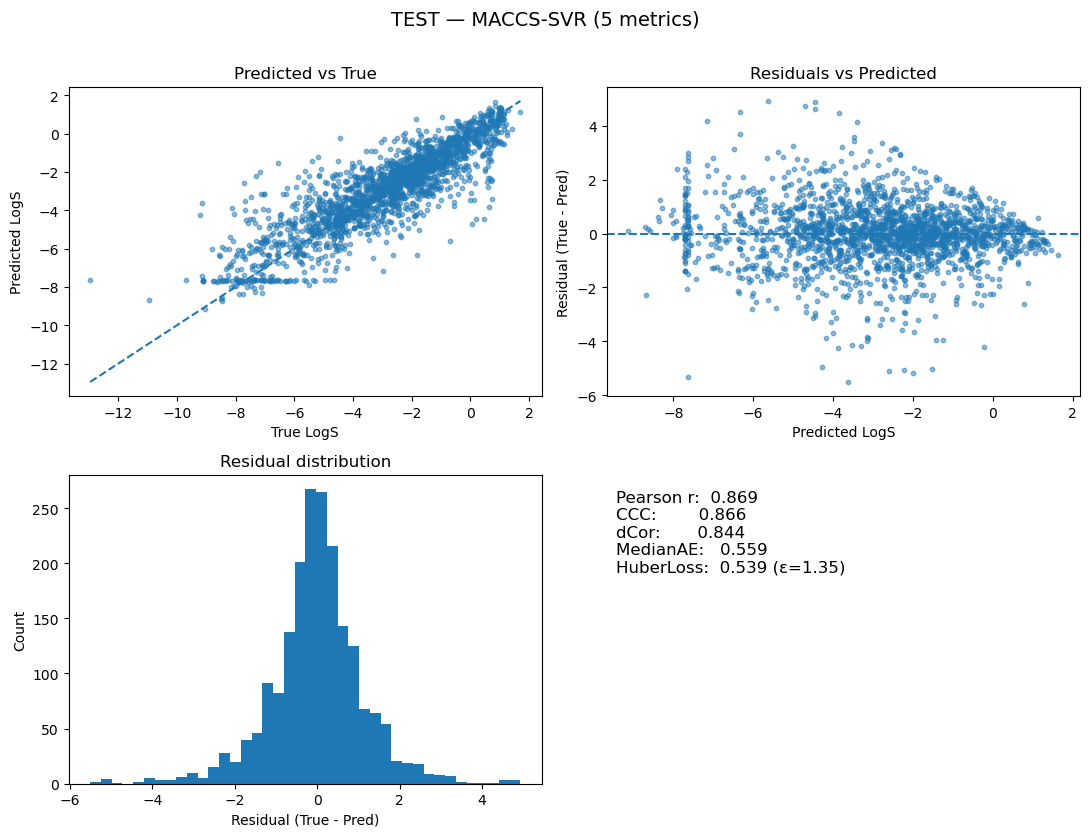

{'Pearson_r': 0.8692775862269538,
 'CCC': 0.865573340872029,
 'dCor': 0.843859170573052,
 'MedianAE': 0.5591891742553698,
 'HuberLoss': 0.5385808722823413}

In [27]:
# 5 metrics on MACCS test split

yhat_rf  = np.asarray(res_rf["yhat"])
yhat_svr = np.asarray(res_svr["yhat"])

rows = [
    {"dataset": "test_split", "model": "MACCS-RF",  **compute_5_metrics(y_test_maccs, yhat_rf)},
    {"dataset": "test_split", "model": "MACCS-SVR", **compute_5_metrics(y_test_maccs, yhat_svr)},
]
df_maccs_test_5 = pd.DataFrame(rows)
display(df_maccs_test_5.round(4))
df_maccs_test_5.to_csv("results/task4_maccs_test_5metrics.csv", index=False)

comprehensive_plot(y_test_maccs, yhat_rf,
                   "TEST — MACCS-RF (5 metrics)",
                   "figures/task4_5metrics/test_maccs_rf.png")
comprehensive_plot(y_test_maccs, yhat_svr,
                   "TEST — MACCS-SVR (5 metrics)",
                   "figures/task4_5metrics/test_maccs_svr.png")


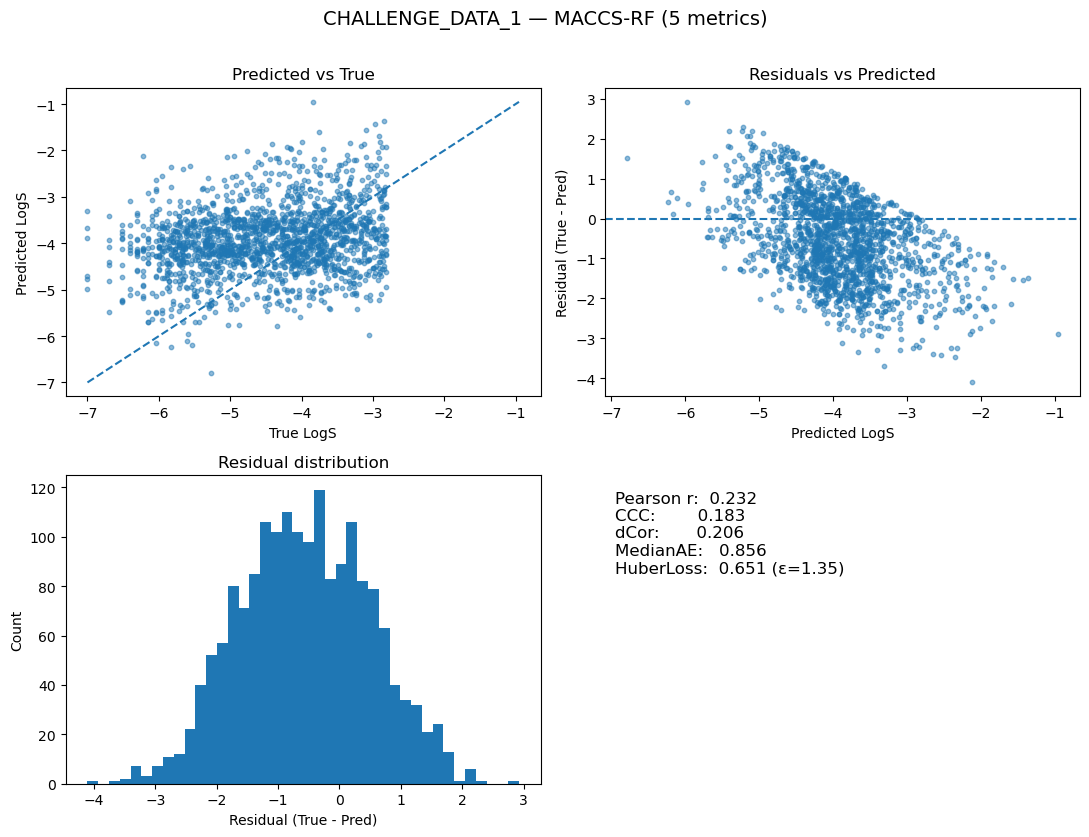

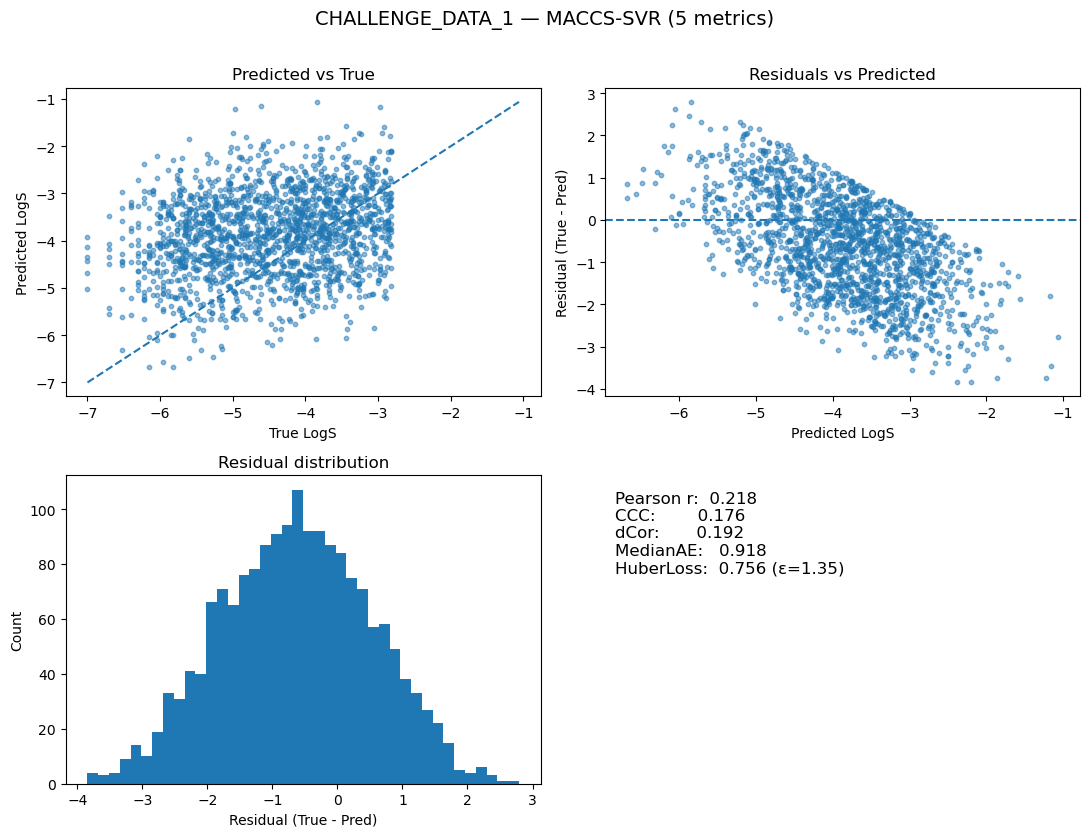

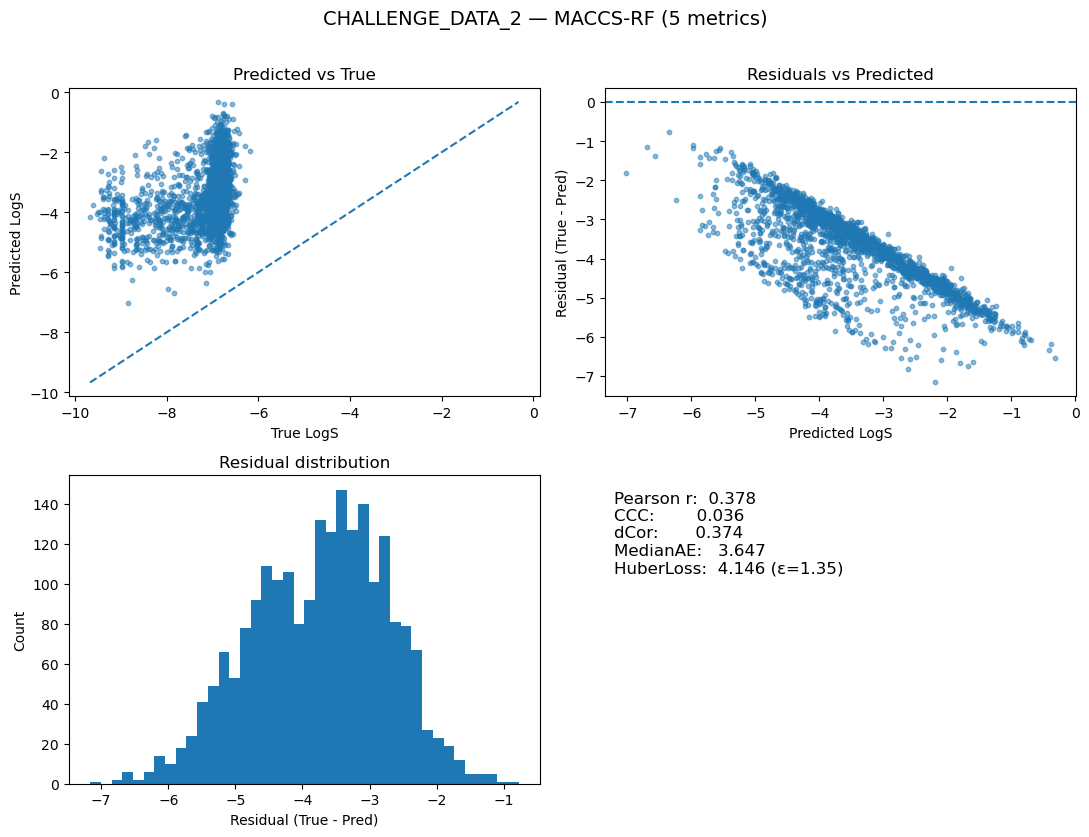

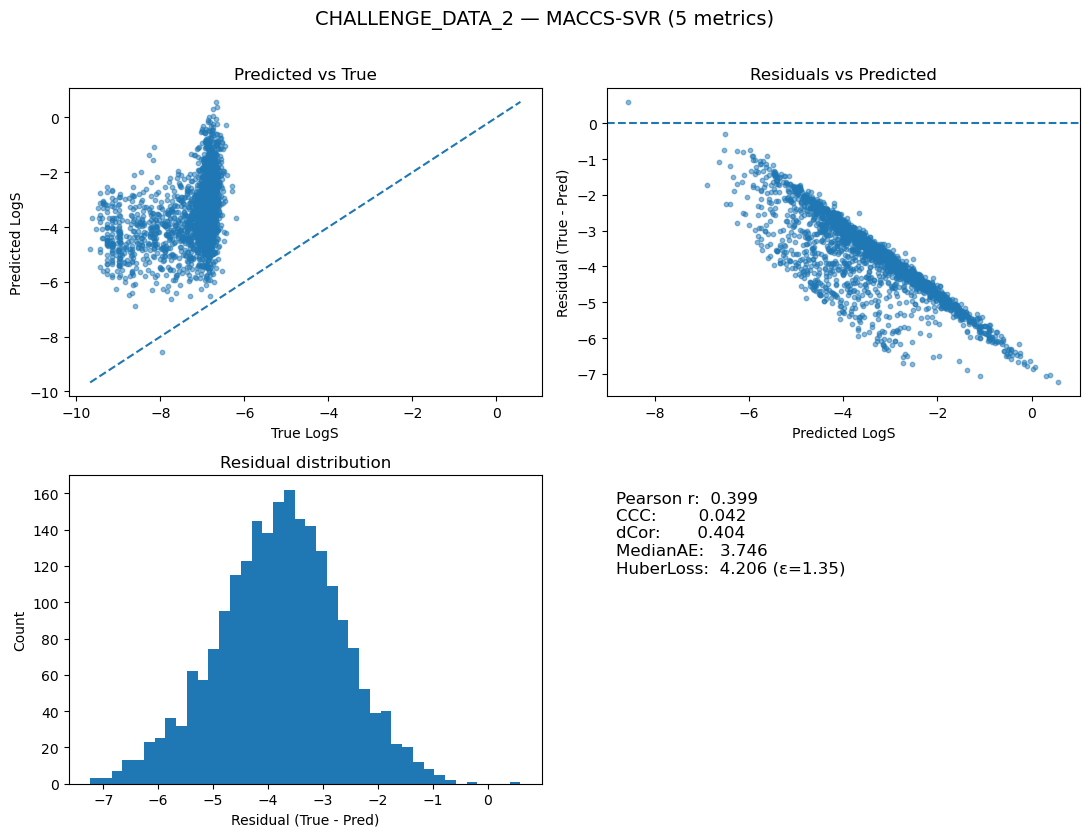

dataset      model  Pearson_r     CCC    dCor  MedianAE  HuberLoss
0  challenge_data_1   MACCS-RF     0.2323  0.1833  0.2058    0.8555     0.6512
1  challenge_data_1  MACCS-SVR     0.2183  0.1764  0.1924    0.9180     0.7563
2  challenge_data_2   MACCS-RF     0.3777  0.0359  0.3738    3.6466     4.1464
3  challenge_data_2  MACCS-SVR     0.3985  0.0416  0.4044    3.7462     4.2056

In [28]:
# Task 4: 5-metric evaluation on MACCS challenge sets (aligning by canonical SMILES)

from rdkit import Chem

def canon_smiles(s):
    if pd.isna(s):
        return None
    m = Chem.MolFromSmiles(str(s))
    return Chem.MolToSmiles(m, canonical=True) if m else None

def load_aligned_truth_pred(truth_csv, pred_csv):
    df_true = pd.read_csv(truth_csv).copy()
    df_pred = pd.read_csv(pred_csv).copy()

    df_true["canonical_smiles"] = df_true["SMILES"].map(canon_smiles)
    df_pred["canonical_smiles"] = df_pred["canonical_smiles"].map(canon_smiles)

    df_true = df_true.dropna(subset=["canonical_smiles", "LogS"])
    df_pred = df_pred.dropna(subset=["canonical_smiles", "y_pred"])
    df_pred = df_pred.groupby("canonical_smiles", as_index=False)["y_pred"].mean()

    df_m = df_true.merge(df_pred, on="canonical_smiles", how="inner")
    y_true = df_m["LogS"].astype(float).values
    y_pred = df_m["y_pred"].astype(float).values
    return y_true, y_pred

rows = []
for f in ["./data/challenge_data_1.csv", "./data/challenge_data_2.csv"]:
    stem = Path(f).stem
    rf_pred_path  = f"results/{stem}_predictions_rf.csv"
    svr_pred_path = f"results/{stem}_predictions_svr.csv"

    y_true_rf, y_pred_rf = load_aligned_truth_pred(f, rf_pred_path)
    y_true_s,  y_pred_s  = load_aligned_truth_pred(f, svr_pred_path)

    rows.append({"dataset": stem, "model": "MACCS-RF",  **compute_5_metrics(y_true_rf, y_pred_rf)})
    rows.append({"dataset": stem, "model": "MACCS-SVR", **compute_5_metrics(y_true_s,  y_pred_s)})

    comprehensive_plot(y_true_rf, y_pred_rf,
                       f"{stem.upper()} — MACCS-RF (5 metrics)",
                       f"figures/task4_5metrics/{stem}_maccs_rf.png")
    comprehensive_plot(y_true_s,  y_pred_s,
                       f"{stem.upper()} — MACCS-SVR (5 metrics)",
                       f"figures/task4_5metrics/{stem}_maccs_svr.png")

df_maccs_ch_5 = pd.DataFrame(rows)
display(df_maccs_ch_5.round(4))
df_maccs_ch_5.to_csv("results/task4_maccs_challenge_5metrics.csv", index=False)


**What the 5 metrics reveal**

On the MACCS test split, both RF and SVR show high Pearson r and dCor and CCC very close to Pearson, with MedianAE around experimental noise, so they learn a strong, well‑calibrated in‑distribution relationship, with SVR slightly better.
On the Mordred test split, RF and SVR also perform very strongly, but here RF is slightly ahead (higher Pearson/CCC/dCor and lower MedianAE/Huber), showing that Mordred descriptors carry rich, accurate solubility signal in‑distribution.

On MACCS Challenge 1, all metrics drop: low Pearson/dCor and low CCC indicate weak transferable signal and poor agreement, with RF only marginally more robust than SVR; Mordred Challenge 1 shows moderate, unbiased performance (Pearson ≈ CCC, low Huber), but with limited ranking precision.

On Challenge 2 for both MACCS and Mordred, Pearson/dCor stay moderate while CCC collapses towards zero and MedianAE/Huber become very large, revealing severe miscalibration under strong domain shift: the models keep some ranking but miss the correct LogS scale.

These diagnostics do not change which model is best in each regime (SVR or RF in‑distribution, RF slightly better on MACCS Challenge 1, both families failing on Challenge 2) but they explain why, by separating trend, agreement, and robustness instead of only reporting RMSE.
